#### To use the Random Forest Survival analysis you will need to use the Pysurvival package.
To install this package please follow the instructions from this site https://square.github.io/pysurvival/installation.html
##### For MacOS users:
You will need to add two more lines besides the recommended 2 as shown below:
###### Note: please check which version of gcc do you have as it might be different from 9.3.0.



### To use the Random Forest Survival analysis we need to load the data and remove the colinear features

In [1]:
import numpy as np
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import os

from pysurvival.utils.display import correlation_matrix
from pysurvival.models.survival_forest import RandomSurvivalForestModel
from pysurvival.utils.metrics import concordance_index
from pysurvival.utils.display import compare_to_actual
from pysurvival.utils.display import integrated_brier_score

from sklearn.model_selection import StratifiedKFold
from statistics import mean 

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
sns.set()
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

In [2]:
from statsmodels.stats.outliers_influence import variance_inflation_factor    

def calculate_vif_(X, thresh=20.0):
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True

    print('Remaining variables:')
    print(X.columns[variables])
    return X.iloc[:, variables]

In [3]:
# feature selection function by VIF and removing low variance features

def feature_select(file_name):
    data = pd.read_csv(file_name)

    data['time column']= data['FFLP_in_months']
    data['event column']= data['FFLP']

    data1=data.drop(columns=['filename', 'Unnamed: 0'])
    lola=data1.iloc[:,0:255]

    time_column='time column'
    event_column='event column'
    features=np.setdiff1d(data1.columns, [time_column, event_column]).tolist()

    #VIF of 10 means that all the features with R^2 above 0.9 will removed
    X = lola
    data2 = calculate_vif_(X, 10)
    data2[['time column']] = lola[['time column']]

    #removing low variance features
    data_temp = data2
    for cols in data2.columns:
        if np.var(data2[cols]) == 0:
            print('Dropping: ' + cols)
            data_temp = data_temp.drop(columns=cols)

    data2 = data_temp
    
    # saving a copy to not repeat VIF again
    processedFileName = 'filtered_' + file_name
    data2.to_csv(processedFileName)

    return data2

In [4]:
# Gridsearch funciton for random survival forest

def gridsearch(data2, file_name):
    
    time_column='time column'
    event_column='event column'
    
    features=np.setdiff1d(data2.columns, [time_column, event_column]).tolist()
    X = data2[features]

    newX=np.setdiff1d(data2.columns, [event_column]).tolist()
    X=data2[newX]
    E=data2['event column']

    num_tree=(10, 12, 15, 20, 50, 100)
    max_depth=(1, 2, 3, 4, 5, 6, 10, 12, 15)
    min_node=(1, 2, 3, 4, 5, 10, 12, 15, 20)
    
    Xnew = X
    Enew = E
    features2 = features

    num_tree_best = 0
    max_depth_best = 0
    min_node_best = 0
    c_index_best = 0

    for a in num_tree:
        for b in max_depth:
            for c in min_node:
                cc=[]
                kf=StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
                i=1
                for train_index, test_index in kf.split(Xnew,Enew):
                    X1_train, X1_test=Xnew.loc[train_index], Xnew.loc[test_index]
                    X_train, X_test=X1_train[features2], X1_test[features2]
                    T_train, T_test=X1_train['time column'].values, X1_test['time column'].values
                    E_train, E_test=Enew.loc[train_index].values, Enew.loc[test_index].values
                    xst = RandomSurvivalForestModel(num_trees=a) 
                    xst.fit(X_train, T_train, E_train, max_features = 'sqrt', max_depth = b,
                    min_node_size = c, num_threads = -1, 
                    sample_size_pct = 0.63, importance_mode = 'normalized_permutation',
                    seed = None, save_memory=False )
                    from pysurvival.utils.metrics import concordance_index
                    c_index = concordance_index(xst, X_test, T_test, E_test)
                    cc.append(c_index)
                i=i+1
                print(a, b, c, mean(cc))
                if mean(cc) > c_index_best:
                    c_index_best = mean(cc)
                    num_tree_best = a
                    max_depth_best = b
                    min_node_best = c
                    
    # saving a copy to not repeat grisearch again
    processedFileName = 'gridsearch_' + file_name           
    toDF = [c_index_best, num_tree_best, max_depth_best, min_node_best]
    gridsearchDF = pd.DataFrame(toDF,columns=['Values'])
    gridsearchDF.to_csv(processedFileName)
    
    return (c_index_best, num_tree_best, max_depth_best, min_node_best)

In [5]:
def generate_survival_model(data2, num_tree_best, max_depth_best, min_node_best):
    # retraining with best gridsearch hyperparameters, manually entering them as variables, probably can automate this from picking out max acc
    # Creating the X, T and E inputs
    
    time_column='time column'
    event_column='event column'
    
    features=np.setdiff1d(data2.columns, [time_column, event_column]).tolist()
    X = data2[features]
    
    newX=np.setdiff1d(data2.columns, [event_column]).tolist()
    
    X=data2[newX]
    E=data2['event column']

    CI = []
    IBS = []

    k_folds = 5
    i=1
    kf=StratifiedKFold(n_splits=k_folds, random_state=42, shuffle=True)
    for train_index, test_index in kf.split(X,E):
        print('\n {} of kfold {}'.format(i,kf.n_splits)) 
        X1_train, X1_test=X.loc[train_index], X.loc[test_index]
        X_train, X_test=X1_train[features], X1_test[features]
        T_train, T_test=X1_train['time column'].values, X1_test['time column'].values
        E_train, E_test=E.loc[train_index].values, E.loc[test_index].values
        xst = RandomSurvivalForestModel(num_trees=num_tree_best) 
        xst.fit(X_train, T_train, E_train, max_features = 'sqrt', max_depth = max_depth_best,
            min_node_size = min_node_best, num_threads = -1, 
            sample_size_pct = 0.63, importance_mode = 'normalized_permutation',
            seed = None, save_memory=False )
        c_index = concordance_index(xst, X_test, T_test, E_test)

        #results = compare_to_actual(xst, X_test, T_test, E_test, is_at_risk = True,  figure_size=(16, 6), 
        #                            metrics = ['rmse', 'mean', 'median'])
        results = compare_to_actual(xst, X_test, T_test, E_test, is_at_risk = True,  figure_size=(16, 6), 
                                metrics = ['rmse', 'mean', 'median'])
        ibs = integrated_brier_score(xst, X_test, T_test, E_test, t_max=100, figure_size=(16,6))
        CI.append(c_index)
        IBS.append(ibs)
        print('C-index: {:.2f}'.format(c_index))
        print('IBS: {:.2f}'.format(ibs))           
        i=i+1

    CIAvg = mean(CI)
    CIStd = statistics.stdev(CI)
    IBSAvg = mean(IBS)
    IBSStd = statistics.stdev(IBS)
    
    return(CIAvg, CIStd, IBSAvg, IBSStd)


### Main script starts here

In [7]:
# Loading all the data
# Single run of all datasets below, separate single-use code at bottom

gtv = 'gtv.csv'
liver_sub_gtv = 'liver_sub_gtv.csv'
liver_plus_gtv = 'liver_plus_gtv.csv'
gtv0 = 'gtv_0.csv'

gtv_clin_variables = 'gtv_clin_variables.csv'
liver_sub_gtv_clin_variables = 'liver_sub_gtv_clin_variables.csv'
liver_plus_gtv_clin_variables = 'liver_plus_gtv_clin_variables.csv'
gtv0_clin_variables = 'gtv_0_clin_variables.csv'

clin_variables_only = 'clin_variables_only.csv'
data_list = list()
data_list.extend((gtv, liver_sub_gtv, liver_plus_gtv, gtv_clin_variables, liver_sub_gtv_clin_variables, liver_plus_gtv_clin_variables, clin_variables_only, gtv0, gtv0_clin_variables))

Processing: gtv.csv

Feature Selecting... 

Loading existing selected features...


 

Running gridsearch on: gtv.csv

Loading existing gridsearch hyperparameters...

Evaluating K-folds with best hyperparameter combination...


 1 of kfold 5


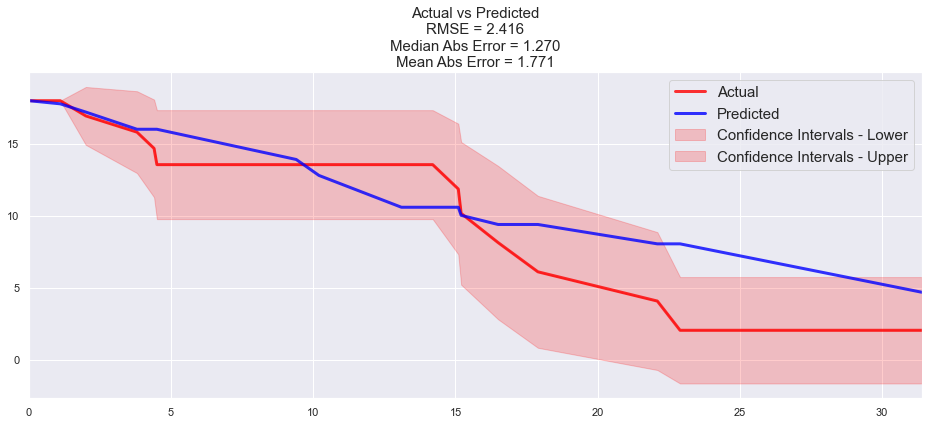

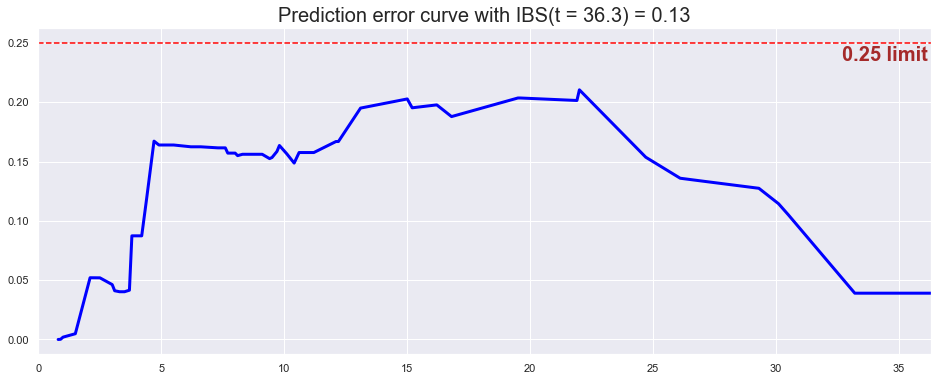

C-index: 0.73
IBS: 0.13

 2 of kfold 5


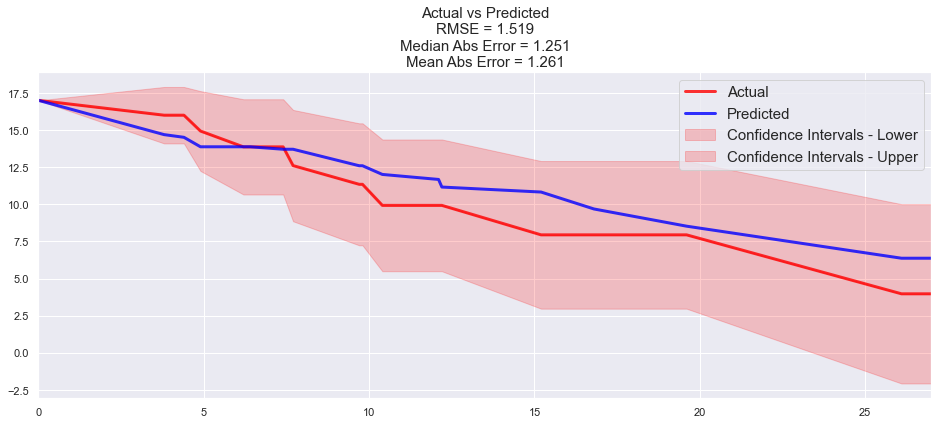

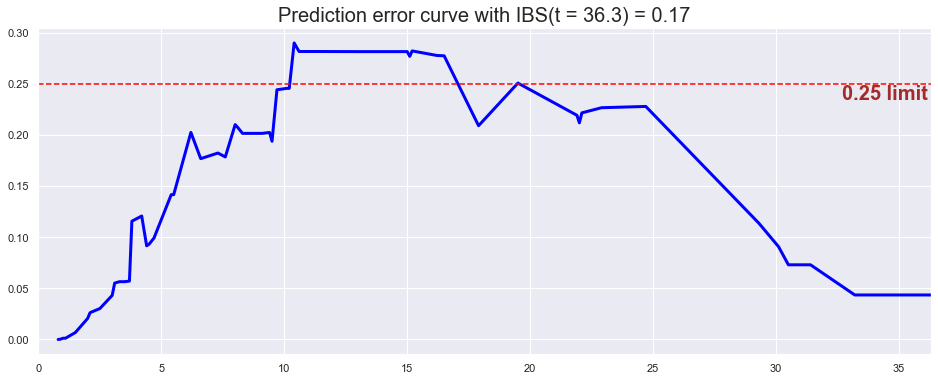

C-index: 0.51
IBS: 0.17

 3 of kfold 5


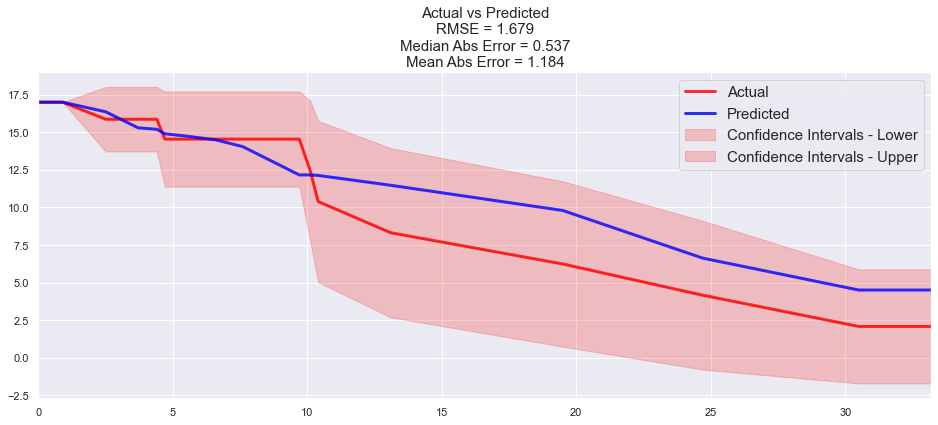

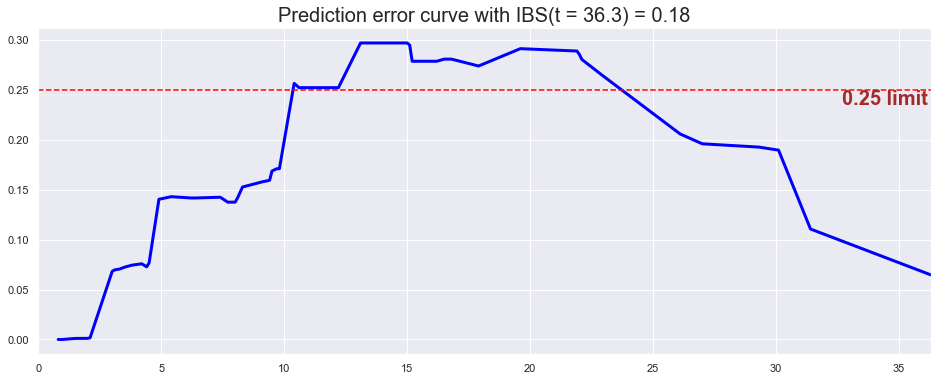

C-index: 0.55
IBS: 0.18

 4 of kfold 5


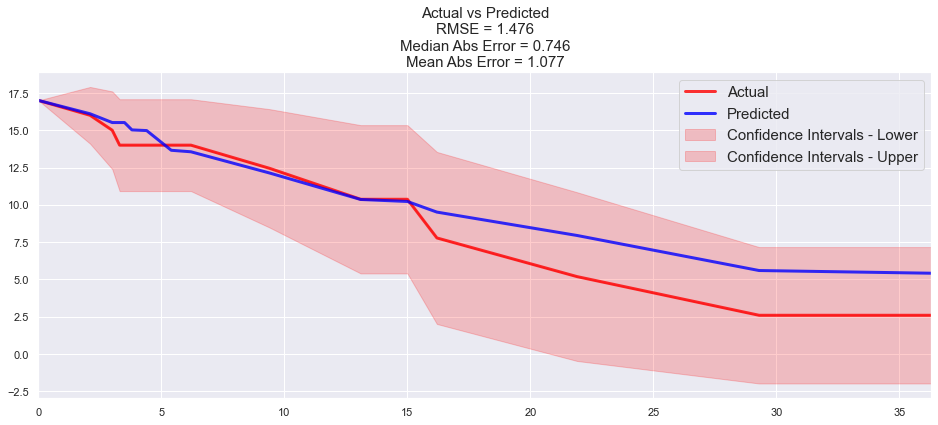

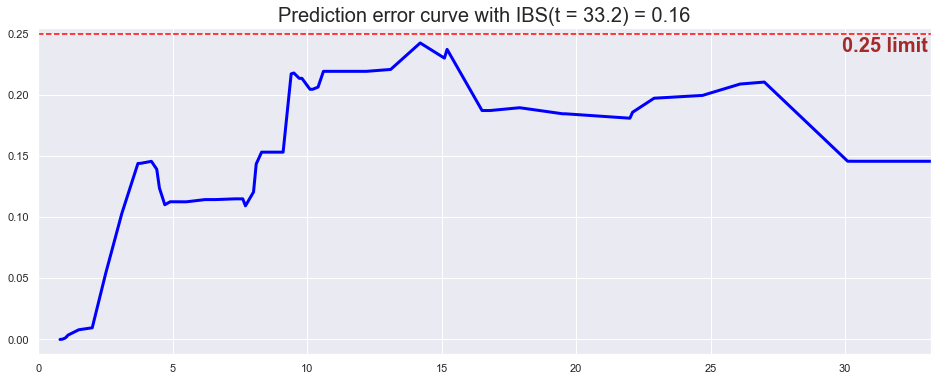

C-index: 0.64
IBS: 0.16

 5 of kfold 5


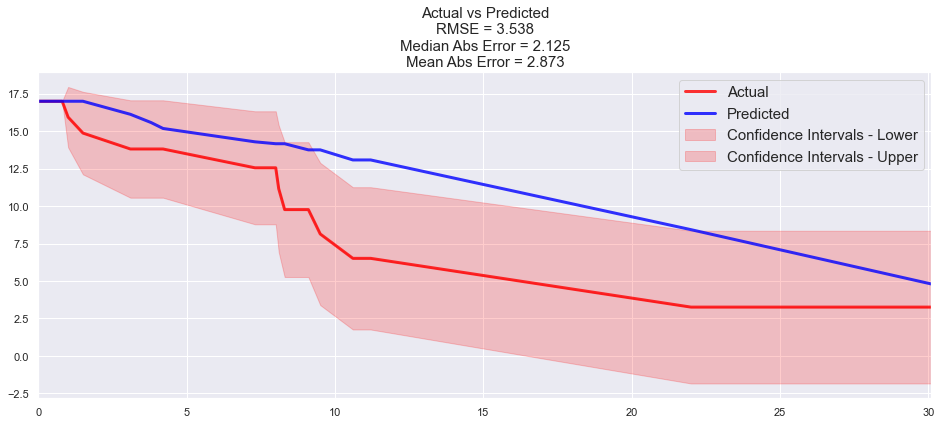

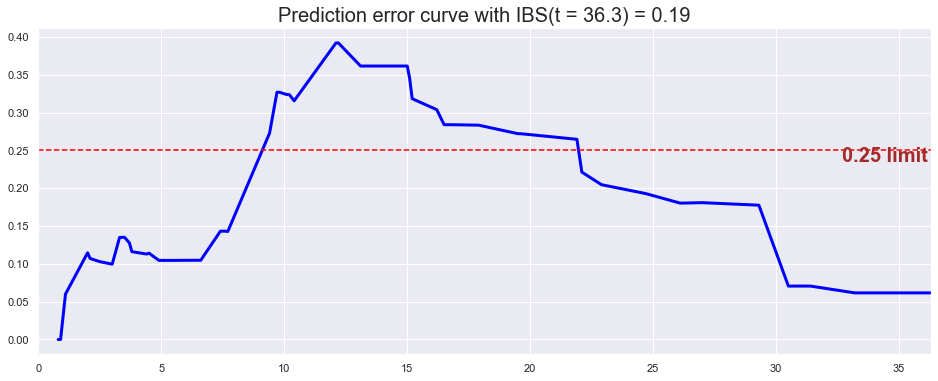

C-index: 0.63
IBS: 0.19

 

Processing: liver_sub_gtv.csv

Feature Selecting... 

Loading existing selected features...


 

Running gridsearch on: liver_sub_gtv.csv

Loading existing gridsearch hyperparameters...

Evaluating K-folds with best hyperparameter combination...


 1 of kfold 5


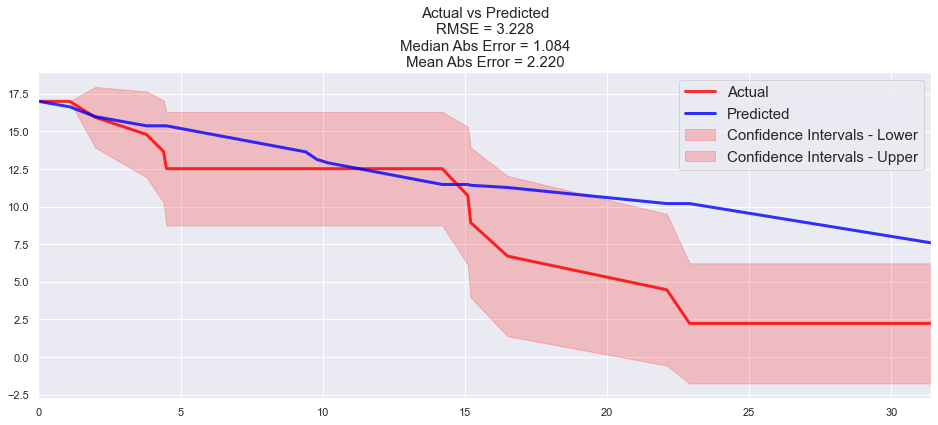

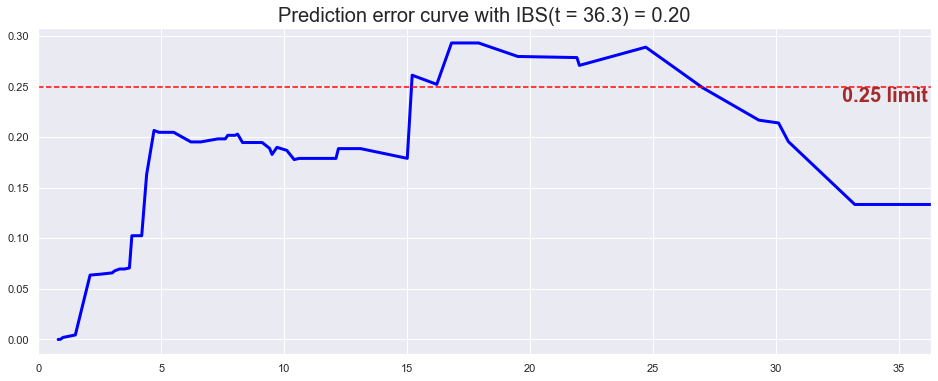

C-index: 0.60
IBS: 0.20

 2 of kfold 5


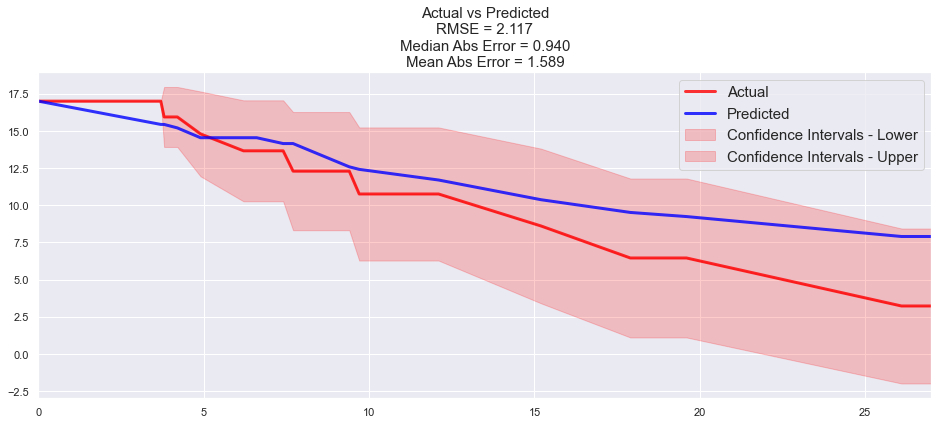

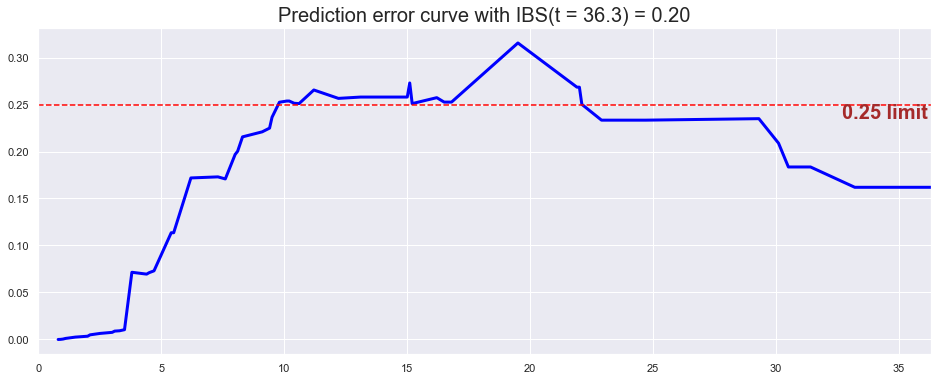

C-index: 0.62
IBS: 0.20

 3 of kfold 5


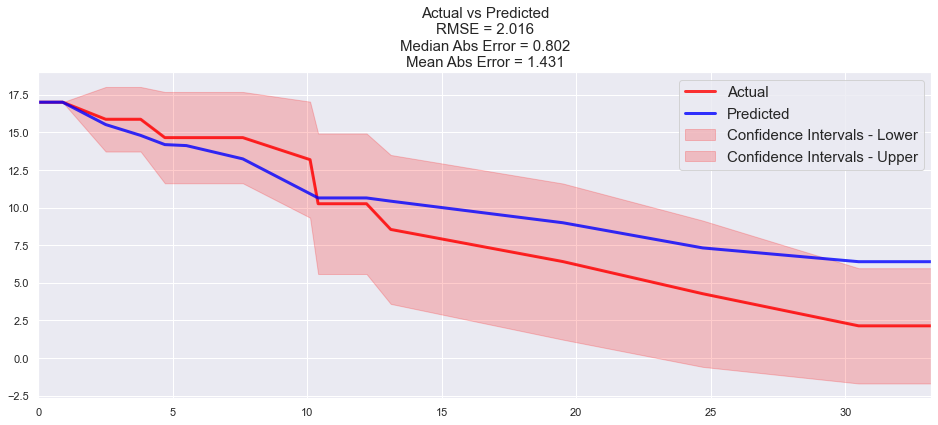

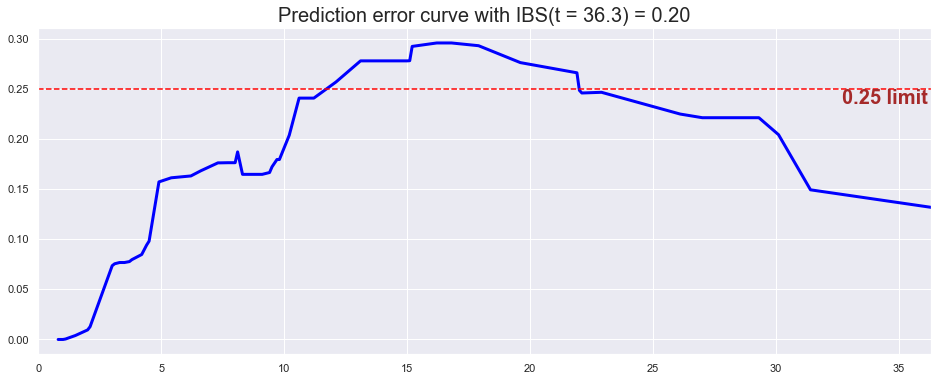

C-index: 0.63
IBS: 0.20

 4 of kfold 5


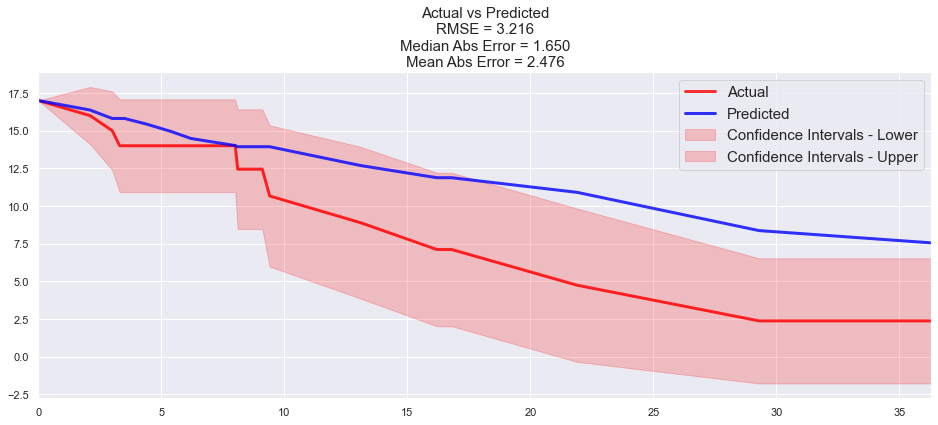

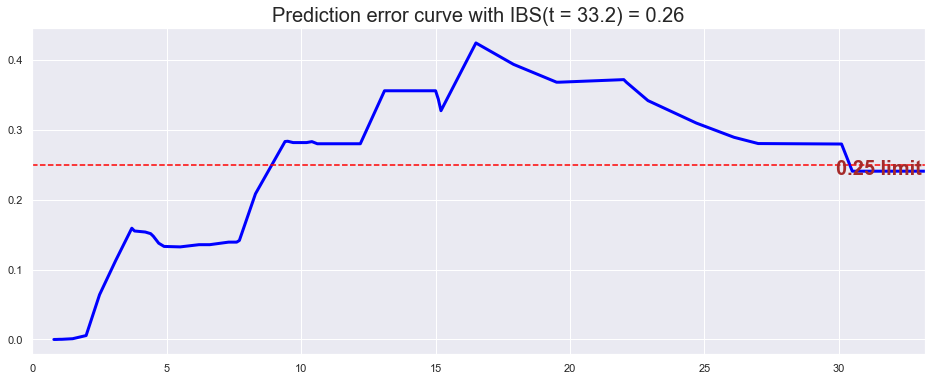

C-index: 0.68
IBS: 0.26

 5 of kfold 5


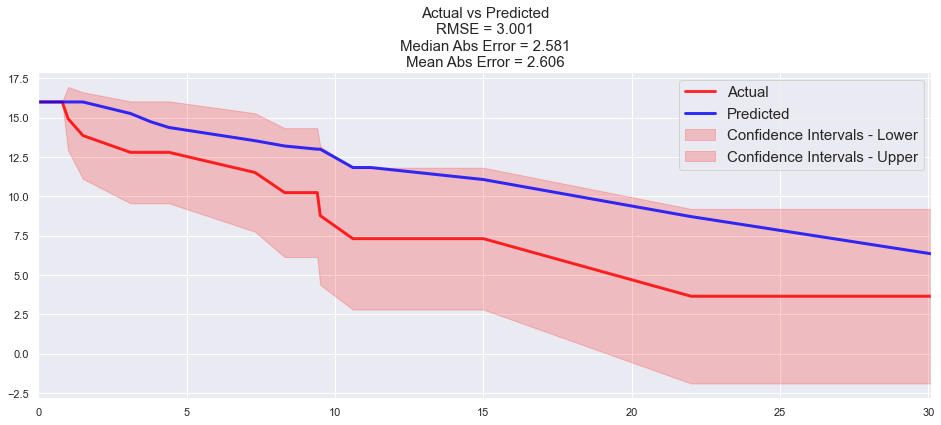

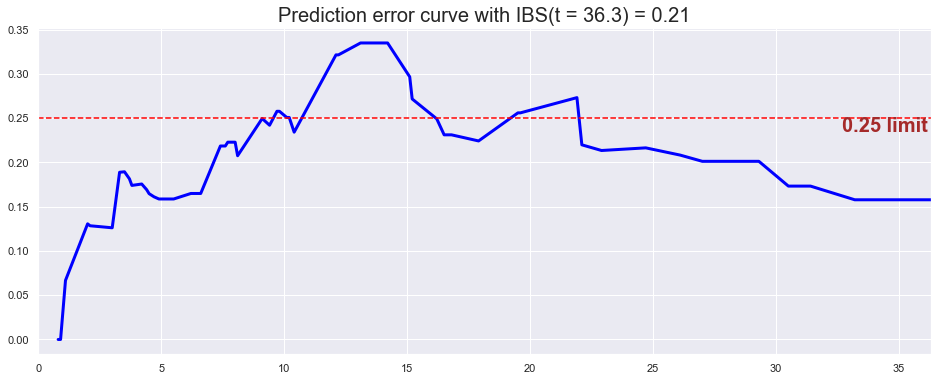

C-index: 0.65
IBS: 0.21

 

Processing: liver_plus_gtv.csv

Feature Selecting... 

Loading existing selected features...


 

Running gridsearch on: liver_plus_gtv.csv

Loading existing gridsearch hyperparameters...

Evaluating K-folds with best hyperparameter combination...


 1 of kfold 5


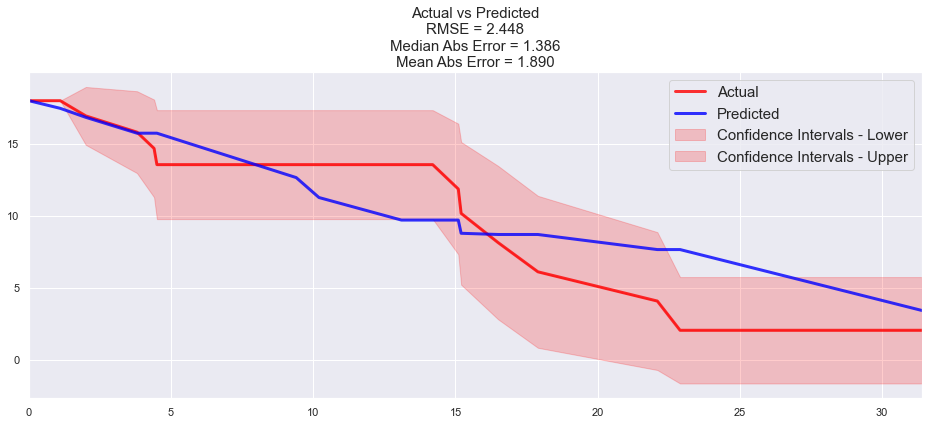

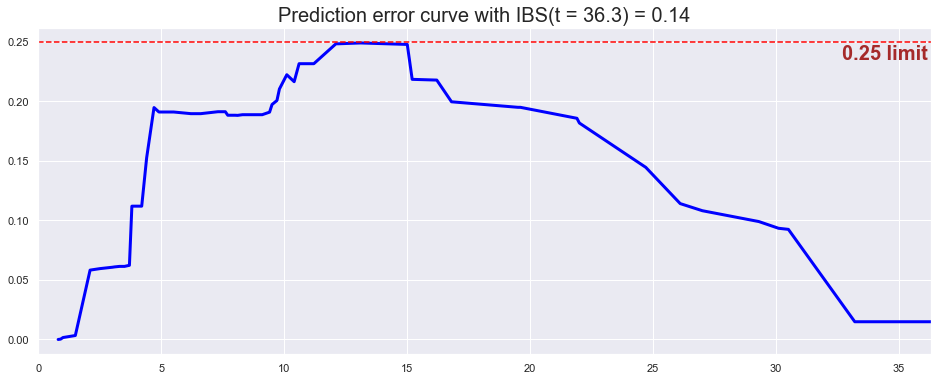

C-index: 0.67
IBS: 0.14

 2 of kfold 5


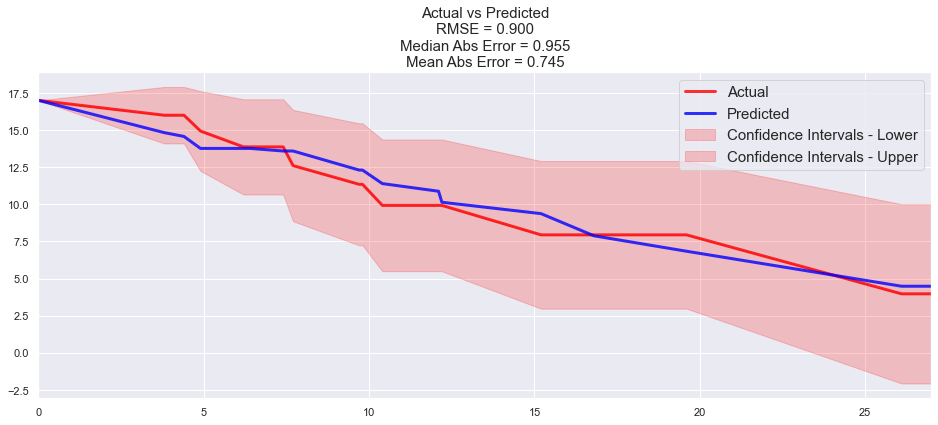

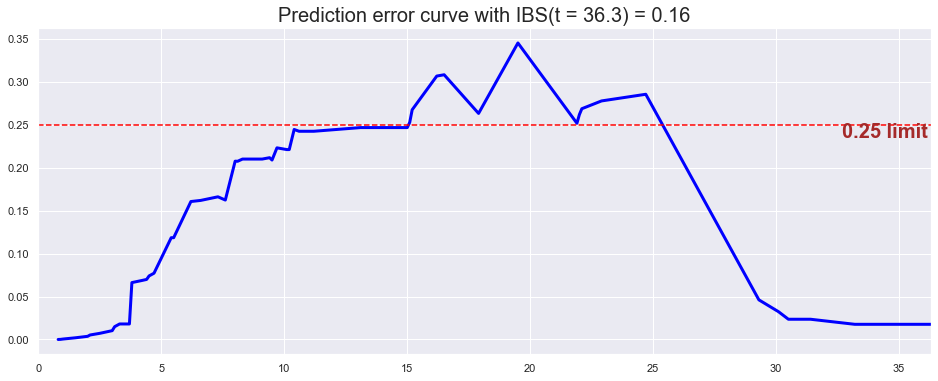

C-index: 0.55
IBS: 0.16

 3 of kfold 5


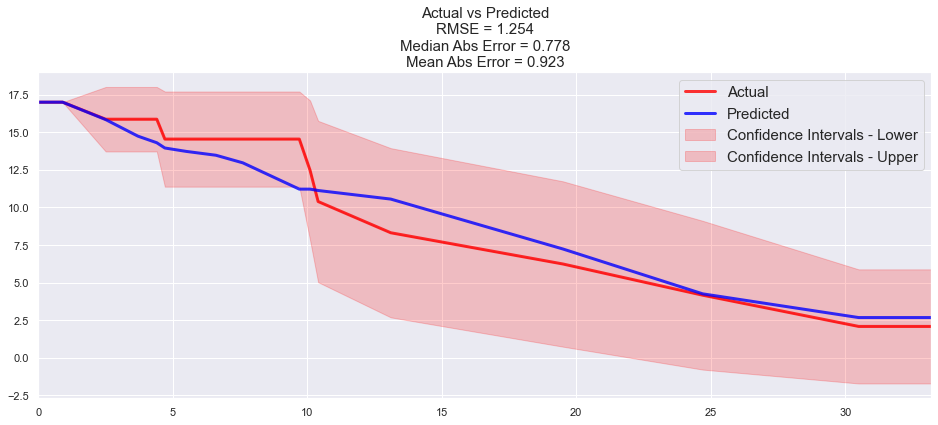

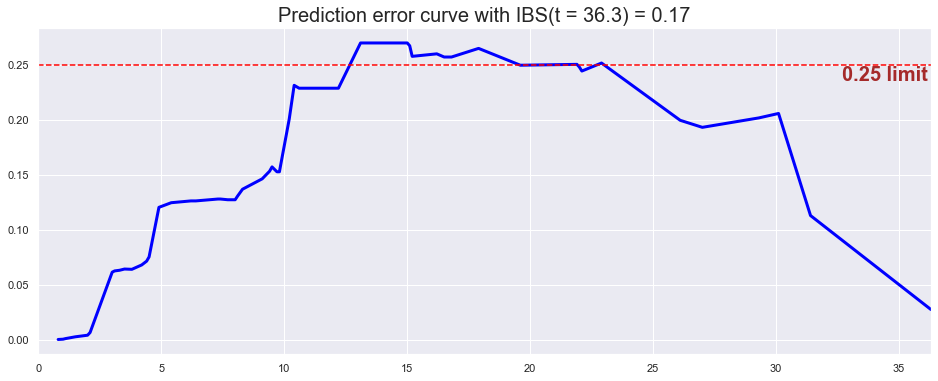

C-index: 0.59
IBS: 0.17

 4 of kfold 5


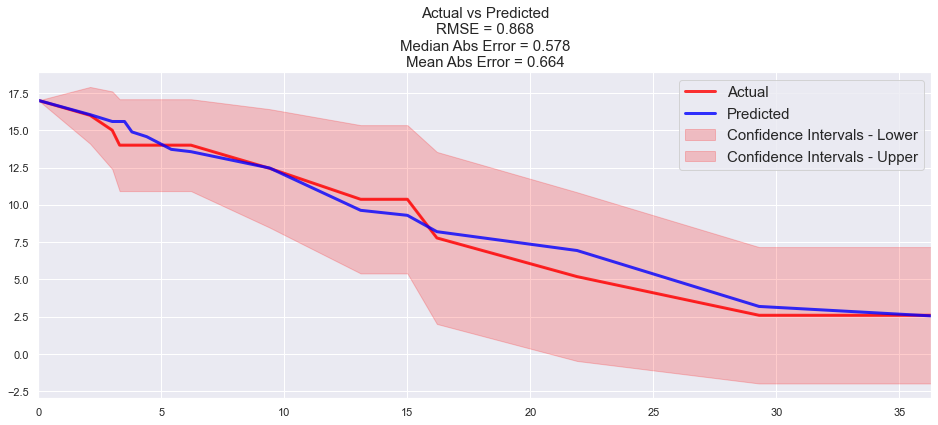

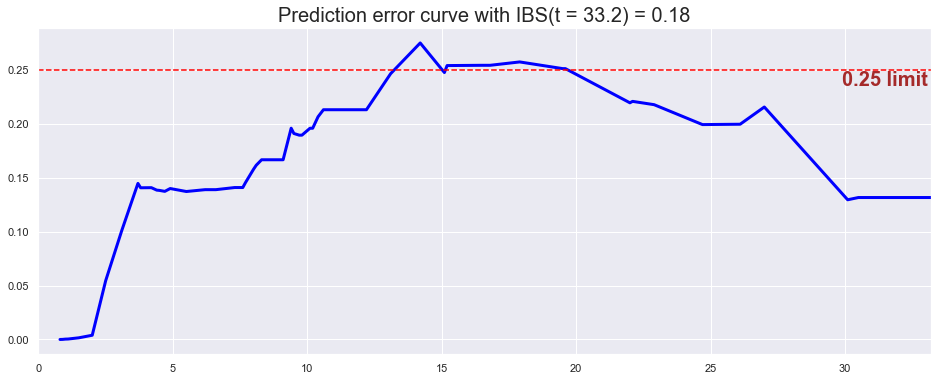

C-index: 0.54
IBS: 0.18

 5 of kfold 5


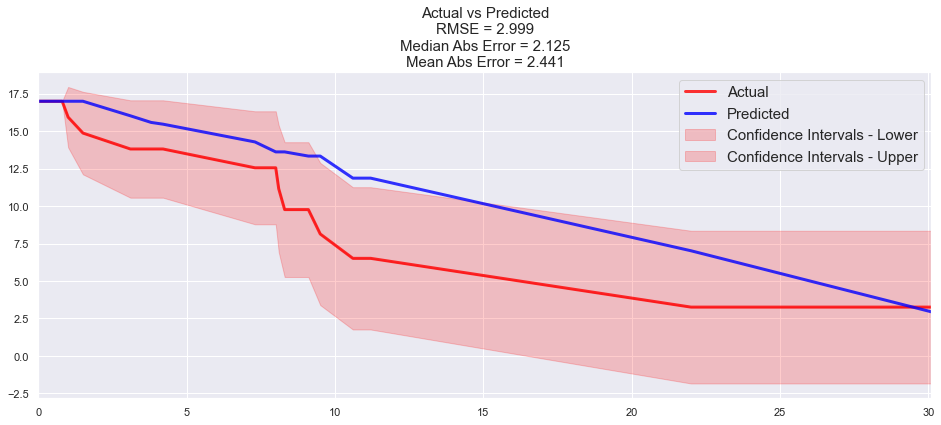

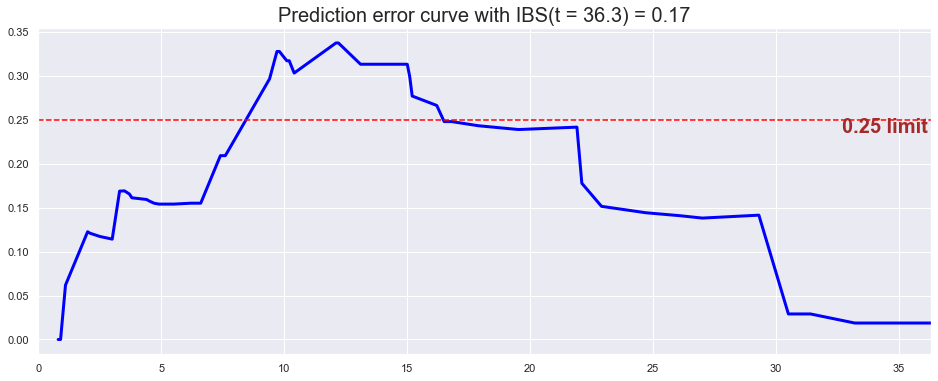

C-index: 0.57
IBS: 0.17

 

Processing: gtv_clin_variables.csv

Feature Selecting... 

Loading existing selected features...


 

Running gridsearch on: gtv_clin_variables.csv

Loading existing gridsearch hyperparameters...

Evaluating K-folds with best hyperparameter combination...


 1 of kfold 5


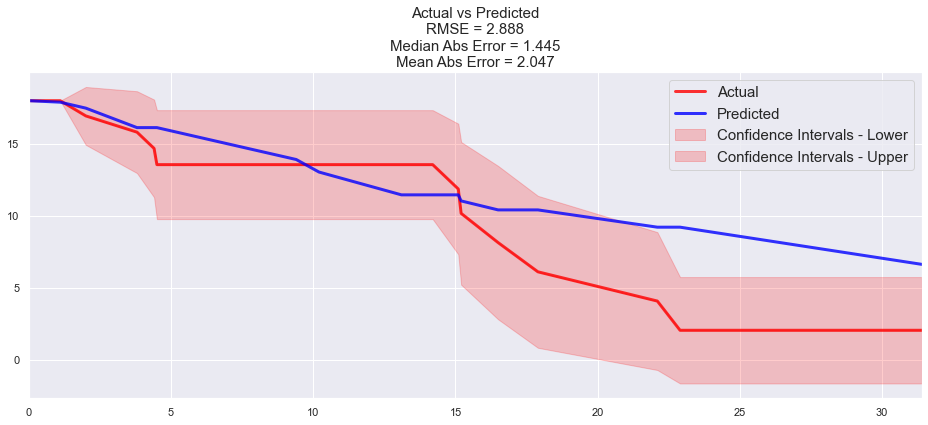

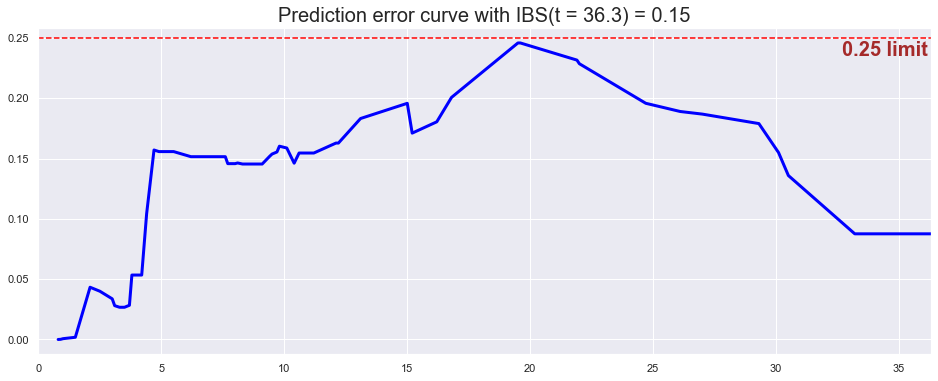

C-index: 0.69
IBS: 0.15

 2 of kfold 5


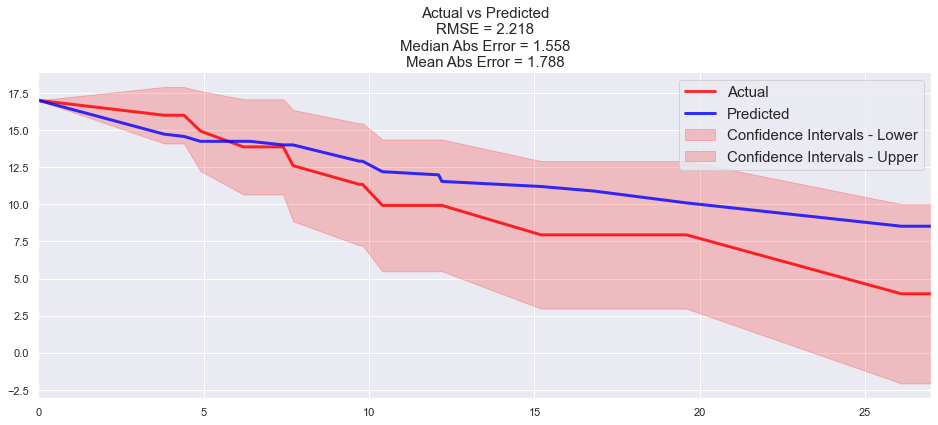

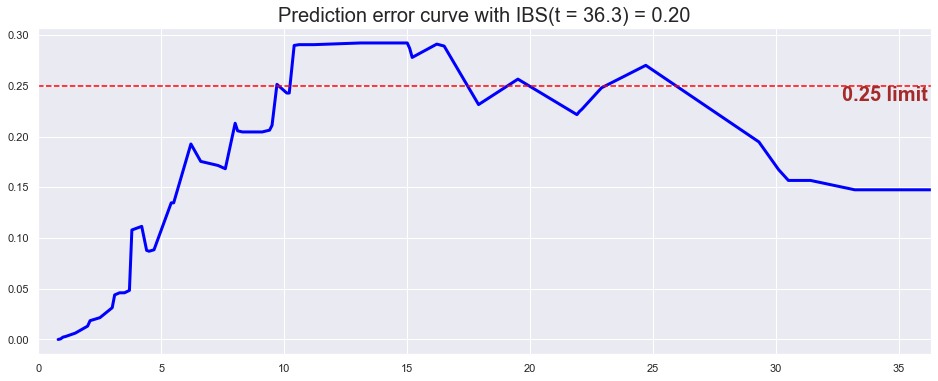

C-index: 0.60
IBS: 0.20

 3 of kfold 5


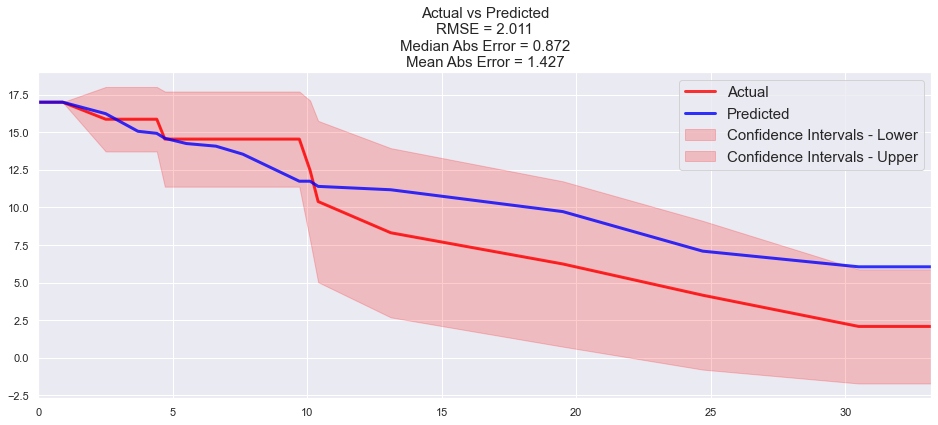

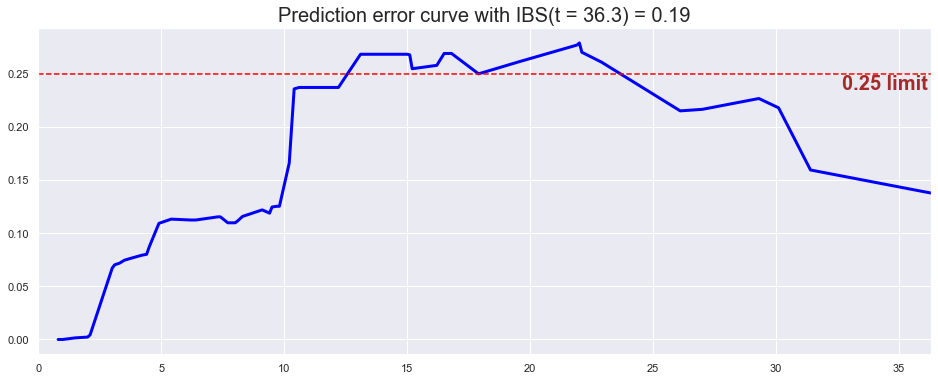

C-index: 0.56
IBS: 0.19

 4 of kfold 5


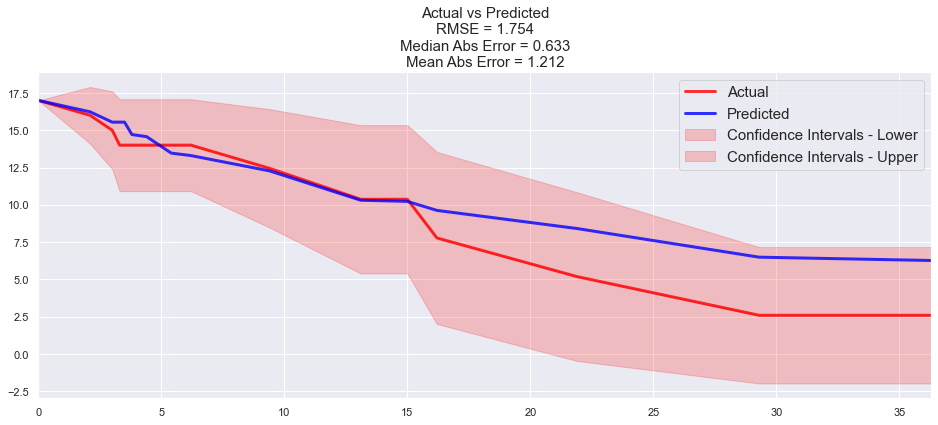

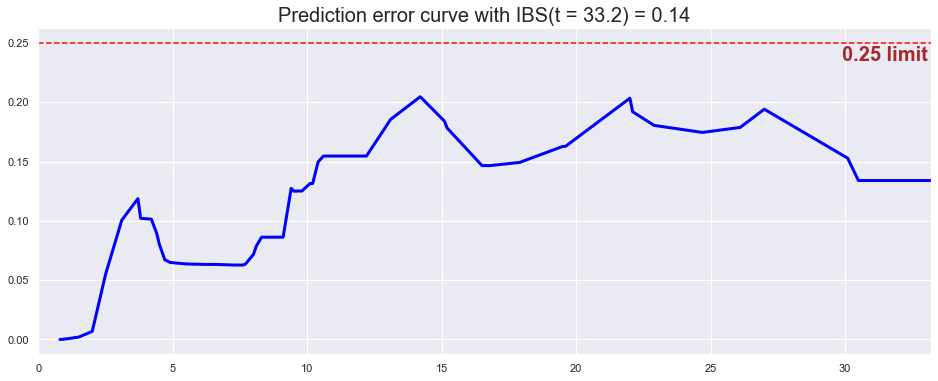

C-index: 0.72
IBS: 0.14

 5 of kfold 5


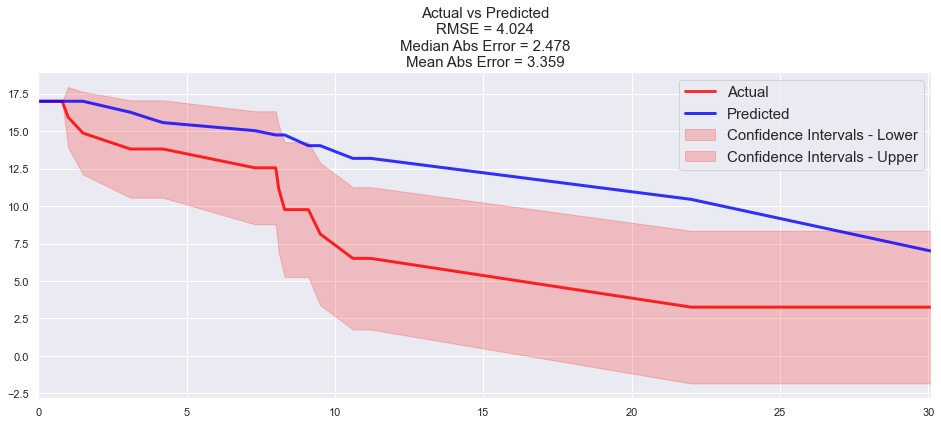

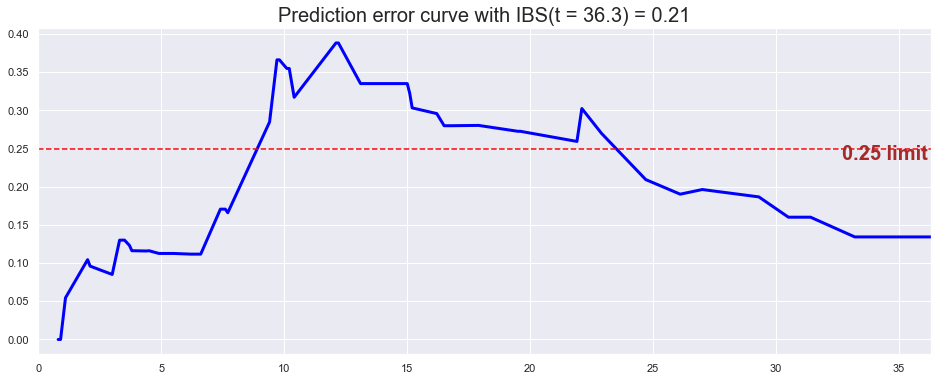

C-index: 0.76
IBS: 0.21

 

Processing: liver_sub_gtv_clin_variables.csv

Feature Selecting... 

Loading existing selected features...


 

Running gridsearch on: liver_sub_gtv_clin_variables.csv

Loading existing gridsearch hyperparameters...

Evaluating K-folds with best hyperparameter combination...


 1 of kfold 5


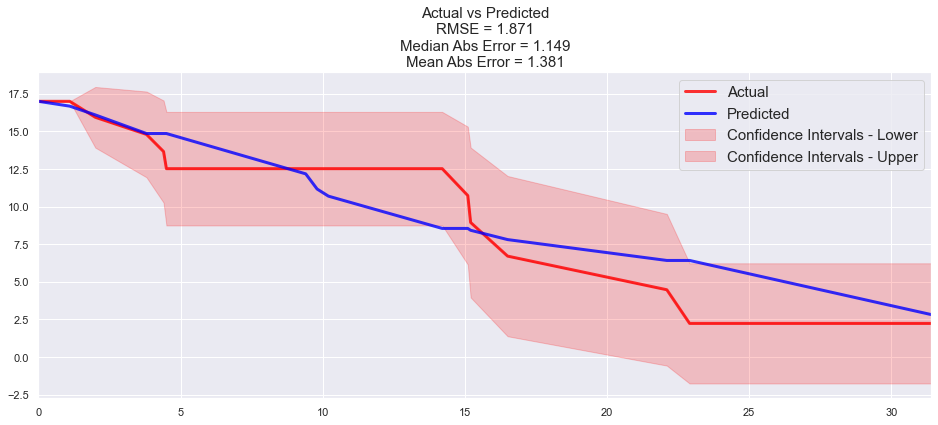

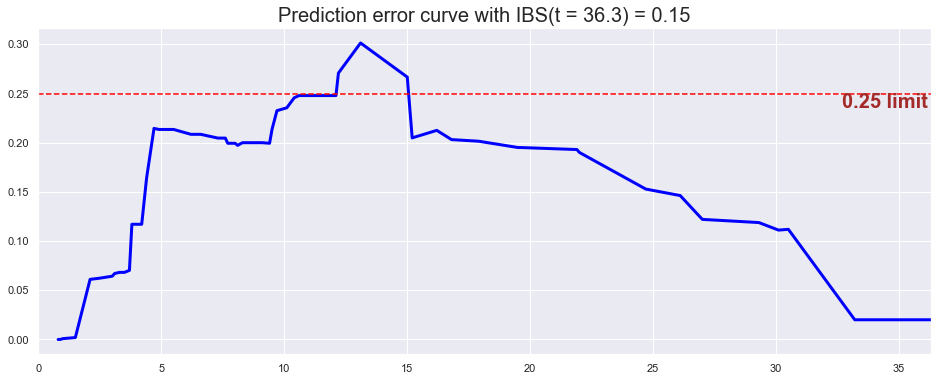

C-index: 0.54
IBS: 0.15

 2 of kfold 5


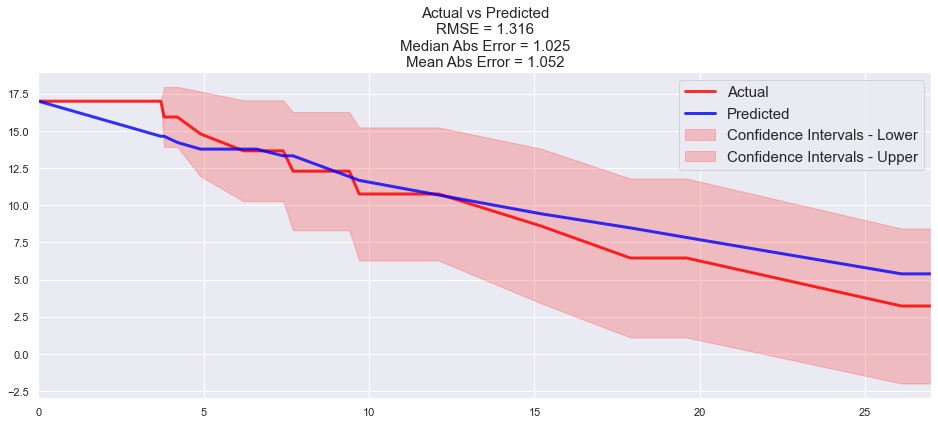

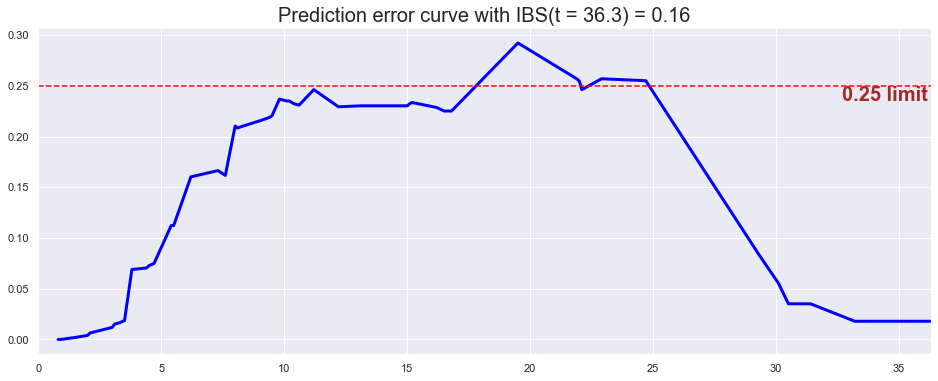

C-index: 0.56
IBS: 0.16

 3 of kfold 5


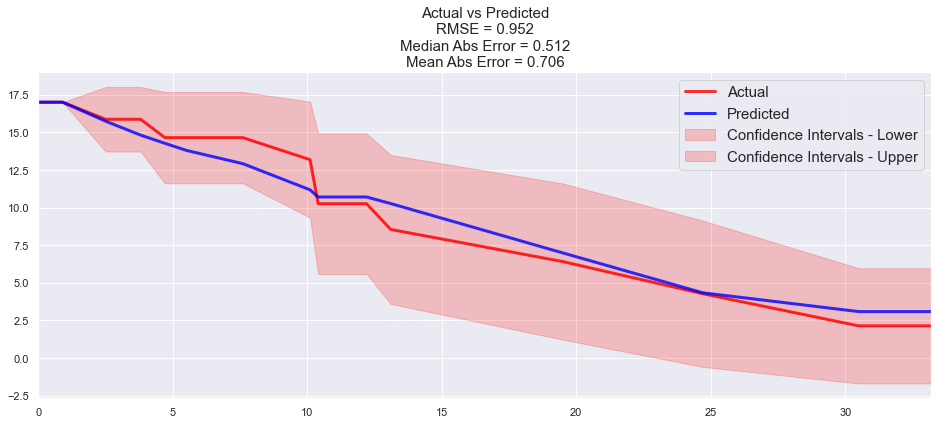

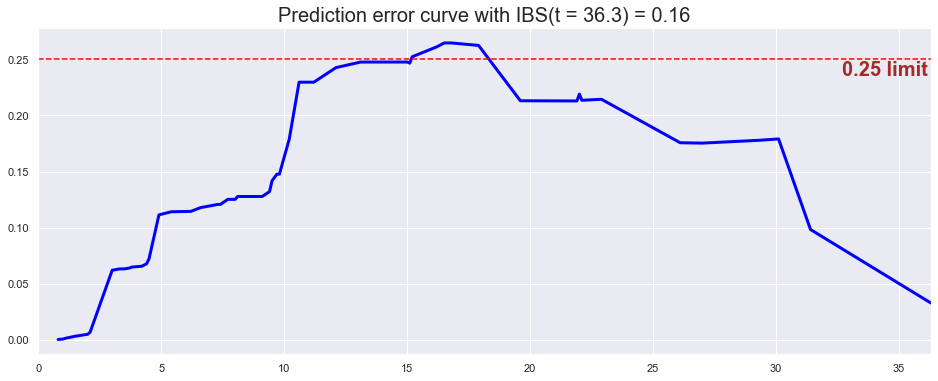

C-index: 0.63
IBS: 0.16

 4 of kfold 5


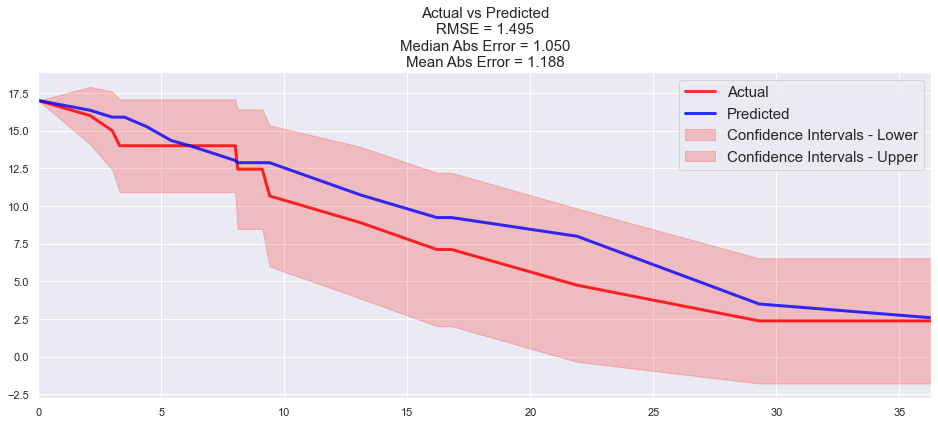

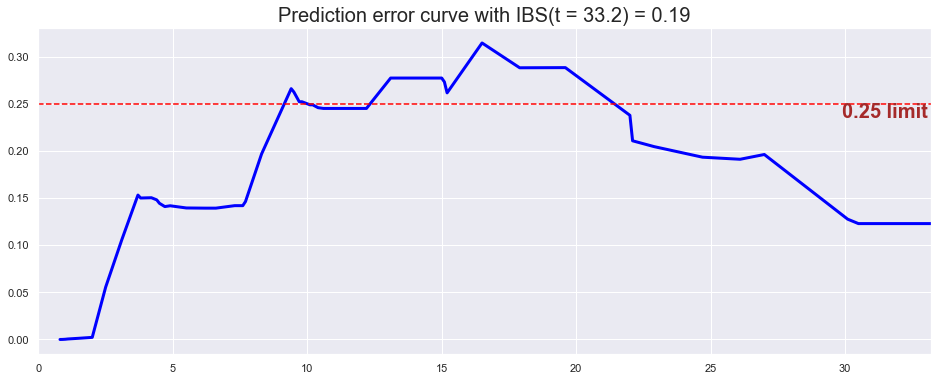

C-index: 0.51
IBS: 0.19

 5 of kfold 5


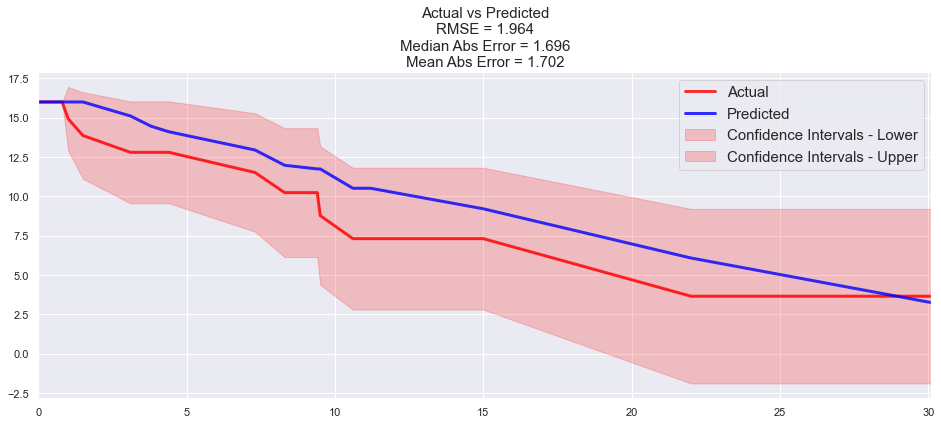

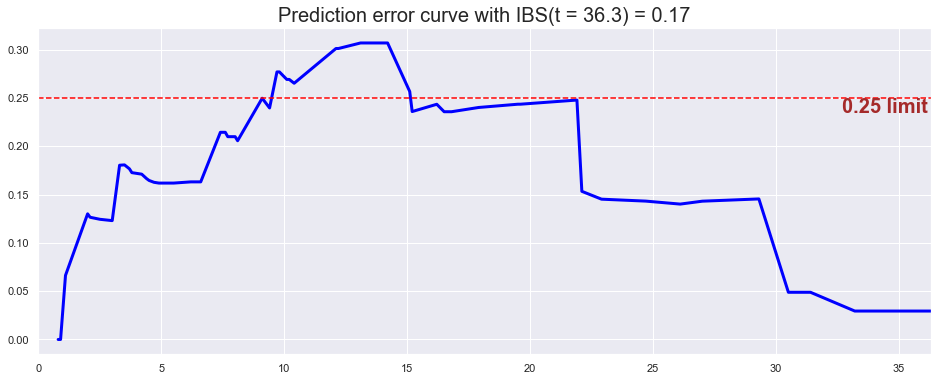

C-index: 0.64
IBS: 0.17

 

Processing: liver_plus_gtv_clin_variables.csv

Feature Selecting... 

Loading existing selected features...


 

Running gridsearch on: liver_plus_gtv_clin_variables.csv

Loading existing gridsearch hyperparameters...

Evaluating K-folds with best hyperparameter combination...


 1 of kfold 5


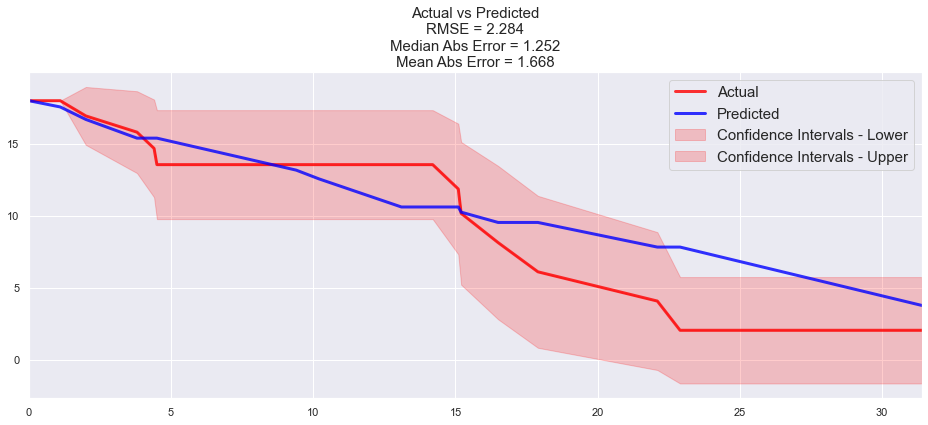

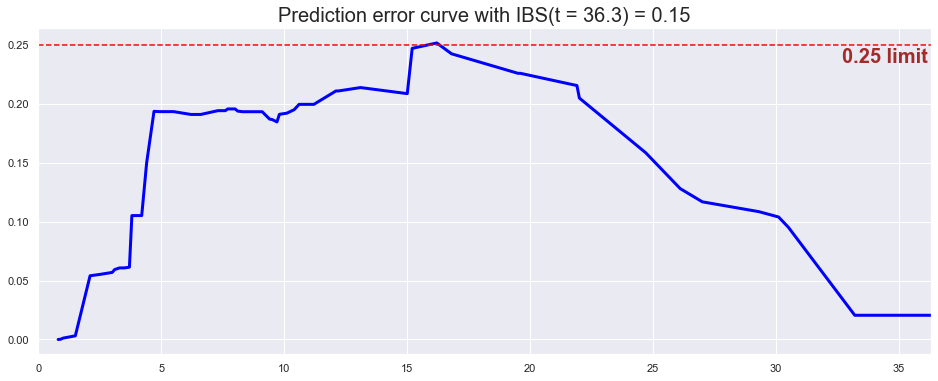

C-index: 0.60
IBS: 0.15

 2 of kfold 5


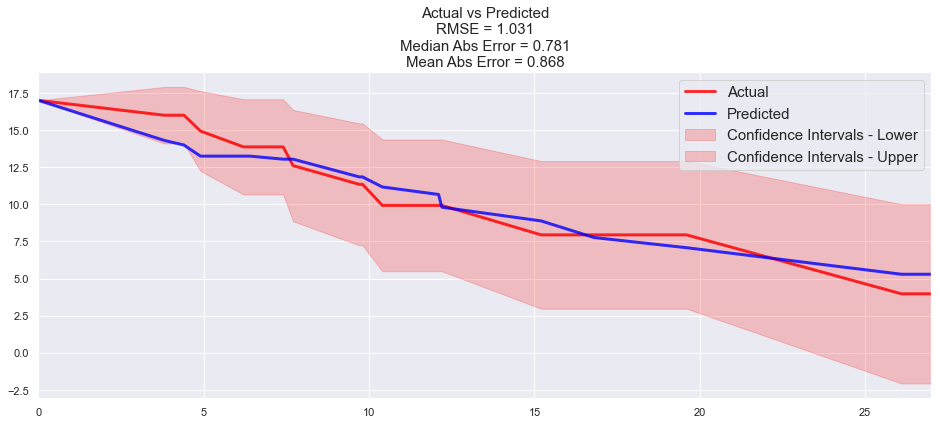

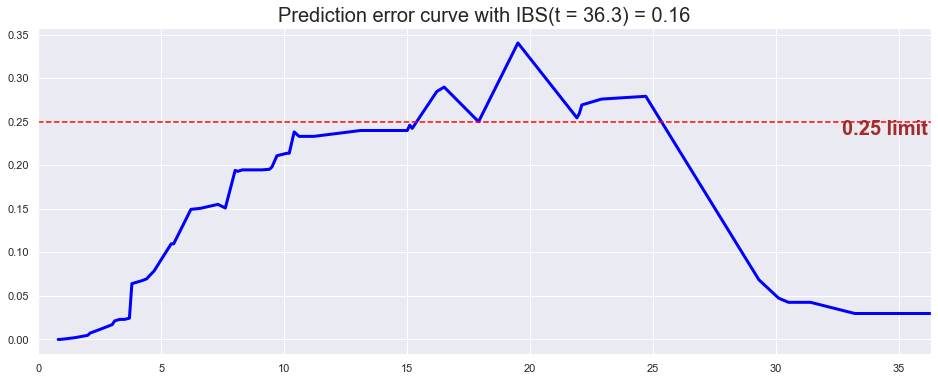

C-index: 0.57
IBS: 0.16

 3 of kfold 5


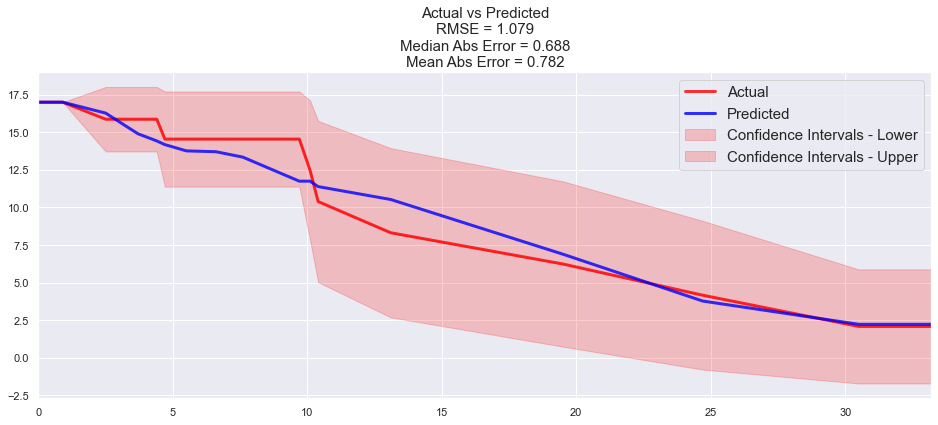

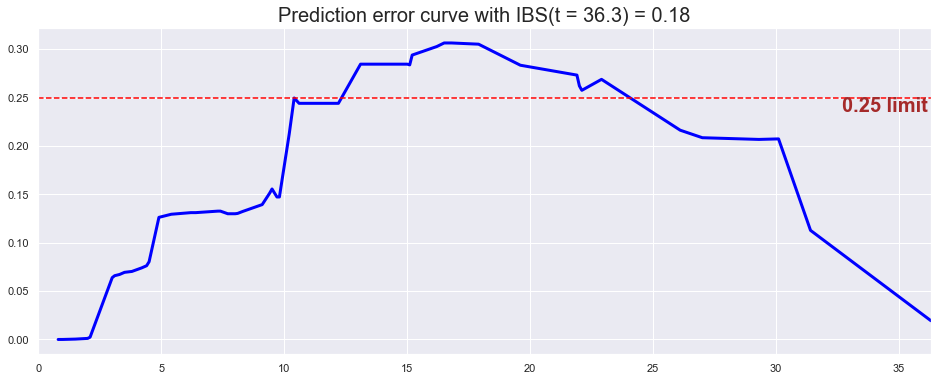

C-index: 0.74
IBS: 0.18

 4 of kfold 5


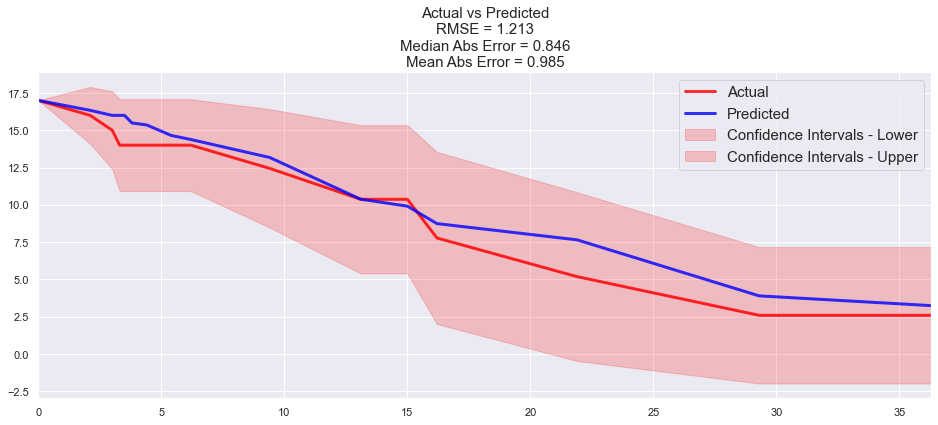

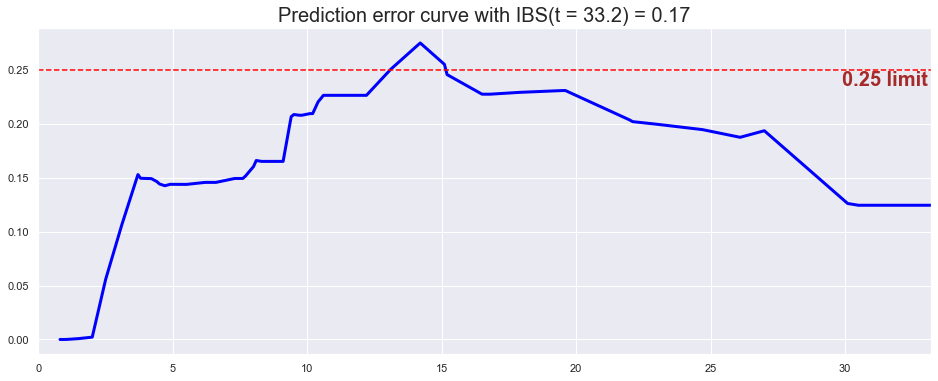

C-index: 0.54
IBS: 0.17

 5 of kfold 5


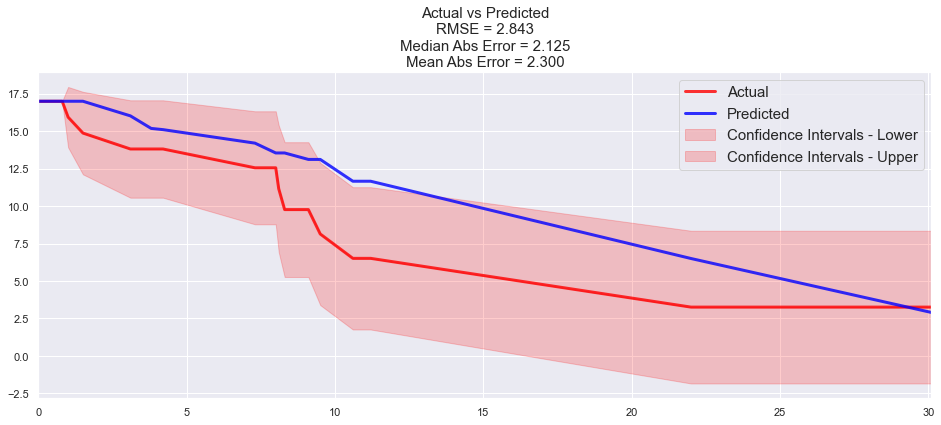

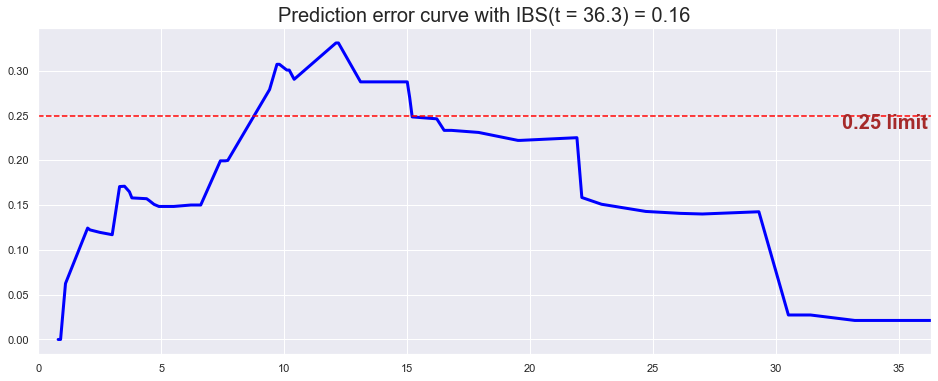

C-index: 0.58
IBS: 0.16

 

Processing: clin_variables_only.csv

Feature Selecting... 

Loading existing selected features...


 

Running gridsearch on: clin_variables_only.csv

Loading existing gridsearch hyperparameters...

Evaluating K-folds with best hyperparameter combination...


 1 of kfold 5


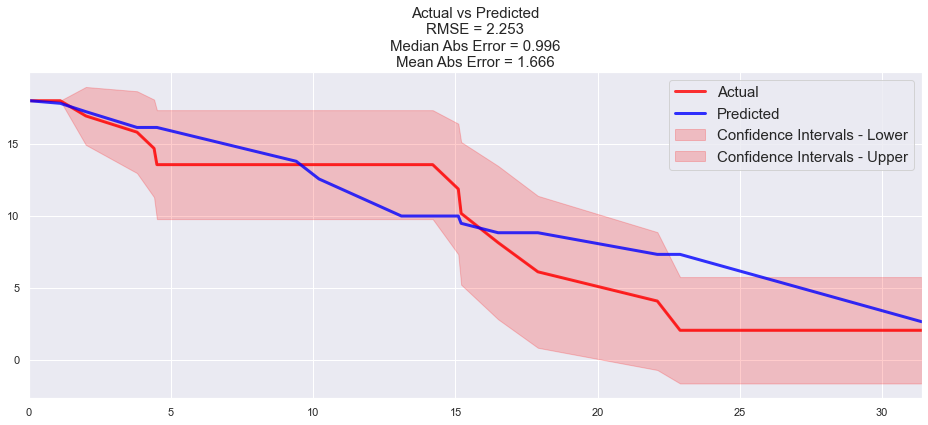

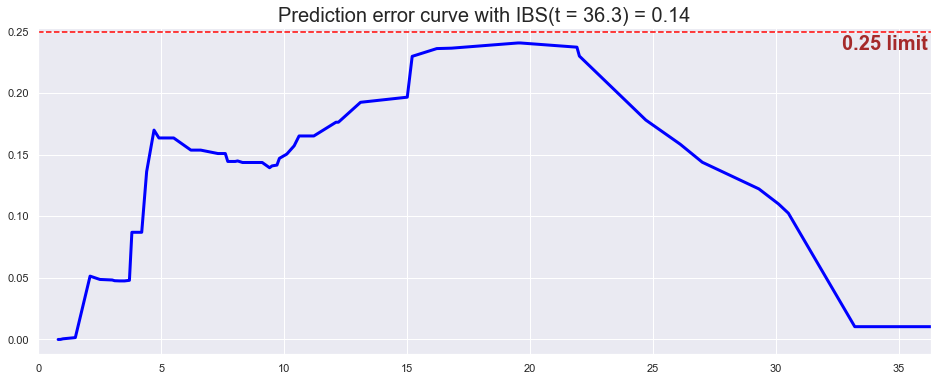

C-index: 0.65
IBS: 0.14

 2 of kfold 5


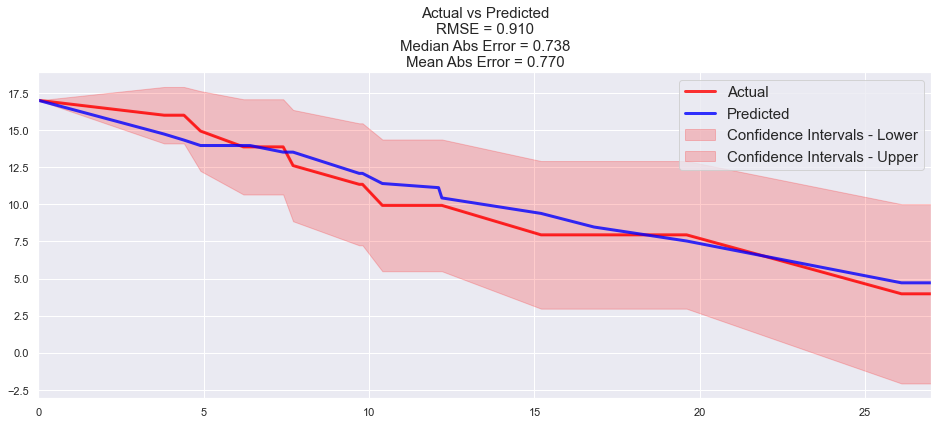

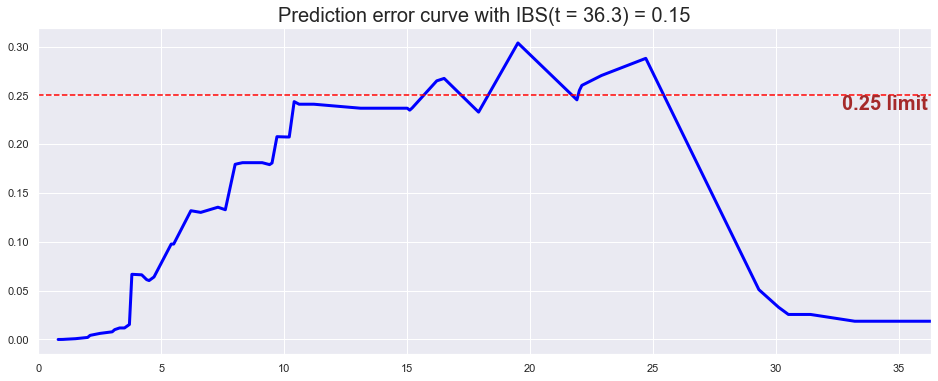

C-index: 0.77
IBS: 0.15

 3 of kfold 5


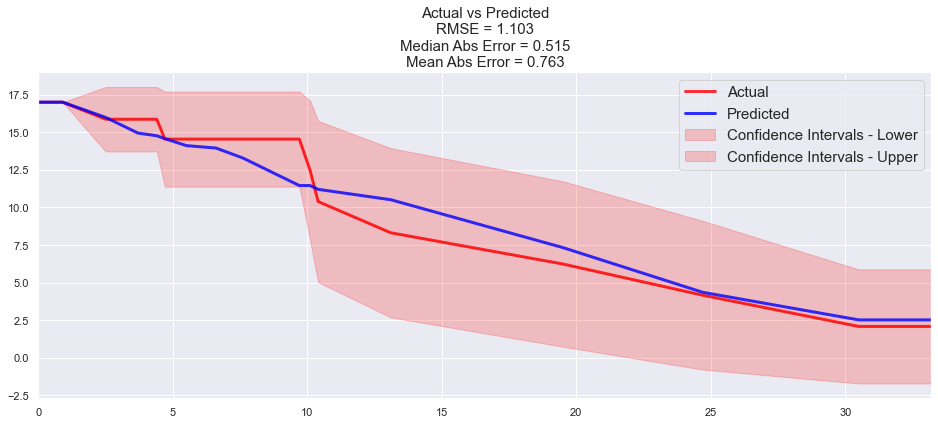

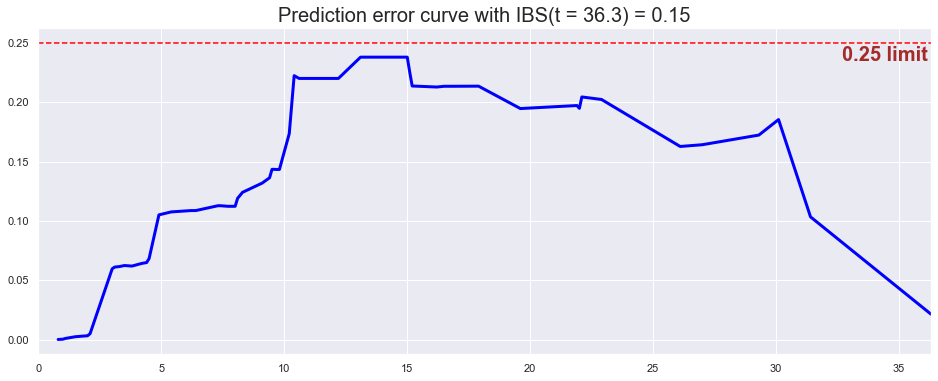

C-index: 0.81
IBS: 0.15

 4 of kfold 5


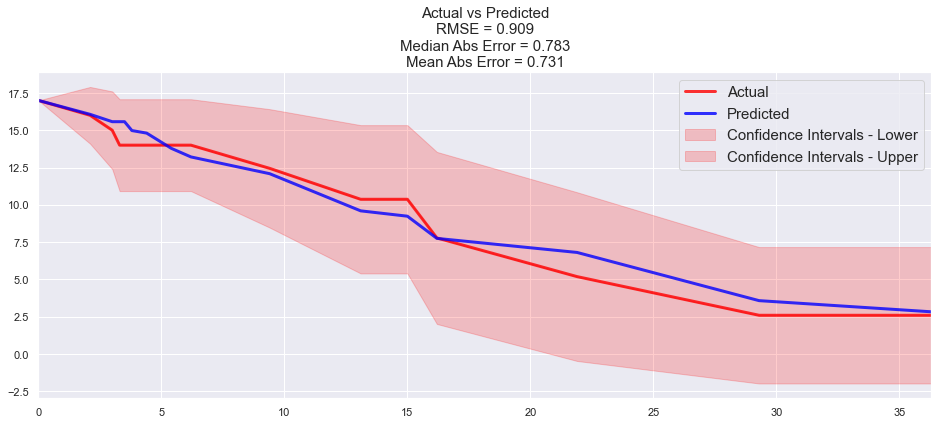

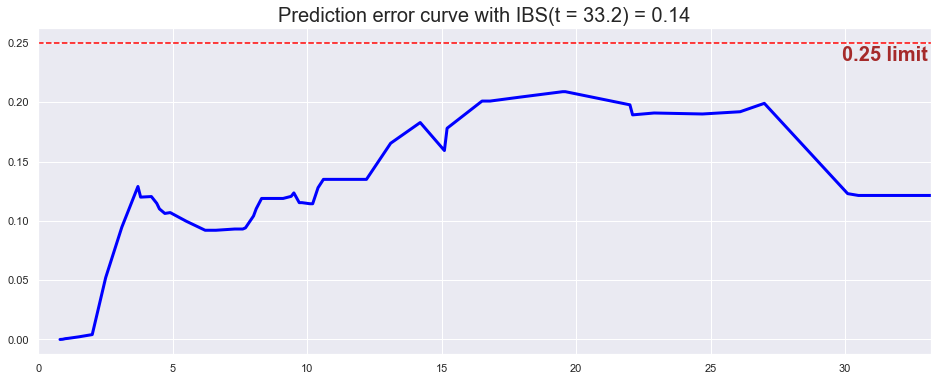

C-index: 0.70
IBS: 0.14

 5 of kfold 5


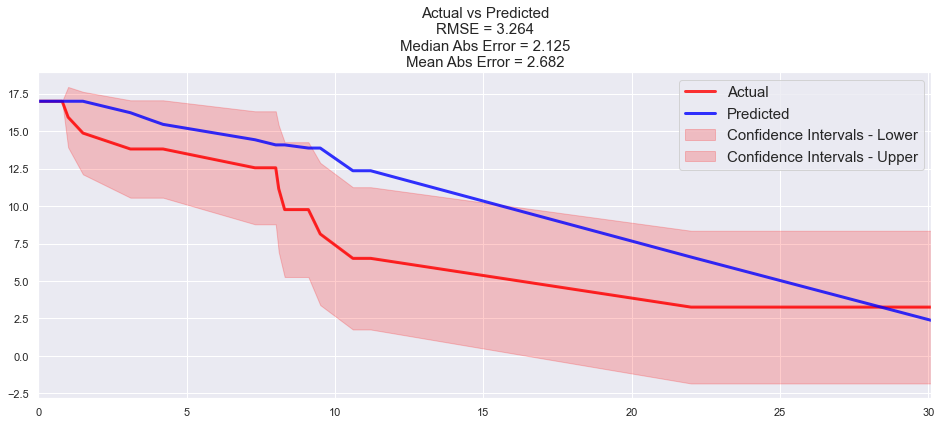

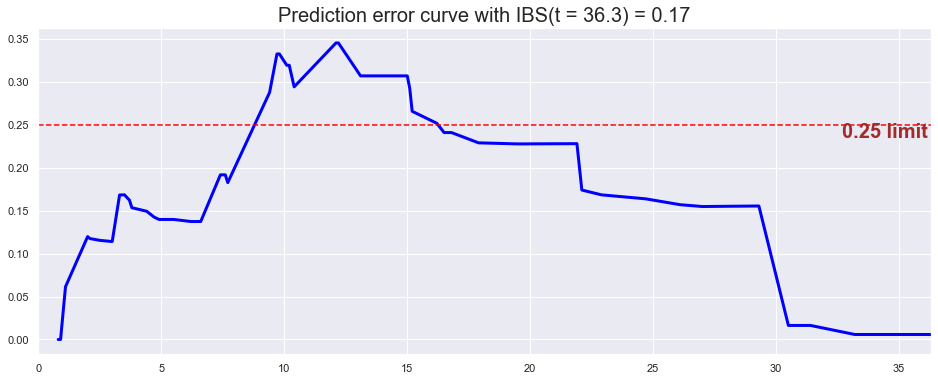

C-index: 0.68
IBS: 0.17

 

Processing: gtv_0.csv

Feature Selecting... 

Computing feature selection...

dropping 'original_firstorder_Energy' at index: 19
dropping 'original_shape_MeshVolume' at index: 11
dropping 'original_glcm_SumSquares' at index: 56
dropping 'original_gldm_GrayLevelVariance' at index: 61
dropping 'original_glszm_LargeAreaEmphasis' at index: 89
dropping 'original_firstorder_Maximum' at index: 21
dropping 'original_glrlm_ShortRunHighGrayLevelEmphasis' at index: 82
dropping 'original_glrlm_GrayLevelNonUniformity' at index: 68
dropping 'original_gldm_HighGrayLevelEmphasis' at index: 60
dropping 'FFLP_in_months' at index: 1
dropping 'original_glcm_SumAverage' at index: 52
dropping 'original_firstorder_Variance' at index: 30
dropping 'original_glrlm_RunVariance' at index: 75
dropping 'original_firstorder_Entropy' at index: 17
dropping 'original_glrlm_RunPercentage' at index: 73
dropping 'original_glcm_Idmn' at index: 40
dropping 'original_glcm_Idm' at index: 39
droppin

10 15 5 0.6594312955792316
10 15 10 0.6100827275043302
10 15 12 0.6406499646512599
10 15 15 0.6181552211915287
10 15 20 0.6757577042821977
12 1 1 0.5886535042472961
12 1 2 0.6436062549951849
12 1 3 0.6892611721252087
12 1 4 0.6396898177179664
12 1 5 0.6387012049063266
12 1 10 0.6323753362356009
12 1 12 0.6226501389848891
12 1 15 0.6598487433620011
12 1 20 0.6579898416443544
12 2 1 0.5912771375269167
12 2 2 0.5905904029722845
12 2 3 0.6516791331324994
12 2 4 0.6755161637424718
12 2 5 0.6600597183390173
12 2 10 0.7004724367528252
12 2 12 0.6257321741112967
12 2 15 0.6505371070786995
12 2 20 0.6652297685893457
12 3 1 0.6447624439396153
12 3 2 0.6974016294180388
12 3 3 0.7106672655036591
12 3 4 0.6603273674978202
12 3 5 0.6617854773375075
12 3 10 0.655306017002615
12 3 12 0.6451138172916541
12 3 15 0.6250747355998433
12 3 20 0.6428825408778587
12 4 1 0.6133799843982575
12 4 2 0.67001061483303
12 4 3 0.7086770523771597
12 4 4 0.6459078075314488
12 4 5 0.6808523873624255
12 4 10 0.6480346876

50 10 12 0.691559225590594
50 10 15 0.6586203184588408
50 10 20 0.677521422842613
50 12 1 0.6594050710795696
50 12 2 0.65236428544288
50 12 3 0.6625121232212167
50 12 4 0.6946651794364889
50 12 5 0.6670689185553663
50 12 10 0.6615600187145845
50 12 12 0.6547960238133299
50 12 15 0.6471116399411218
50 12 20 0.6456281752588909
50 15 1 0.6728101347309409
50 15 2 0.6796734267444923
50 15 3 0.6960396001535447
50 15 4 0.670418894041275
50 15 5 0.637565659809994
50 15 10 0.6849739334899972
50 15 12 0.6616062486071078
50 15 15 0.6433908044083897
50 15 20 0.6433782389097835
100 1 1 0.6814882425987802
100 1 2 0.6376995487573089
100 1 3 0.6871692500693708
100 1 4 0.6747747230560839
100 1 5 0.6639651487917465
100 1 10 0.6742298979344833
100 1 12 0.6991133236349312
100 1 15 0.6472768338912216
100 1 20 0.6811547316779512
100 2 1 0.6905779671459712
100 2 2 0.6729751832724361
100 2 3 0.6588415204899859
100 2 4 0.6682885340110831
100 2 5 0.6746389425130647
100 2 10 0.6896749583074461
100 2 12 0.6713920

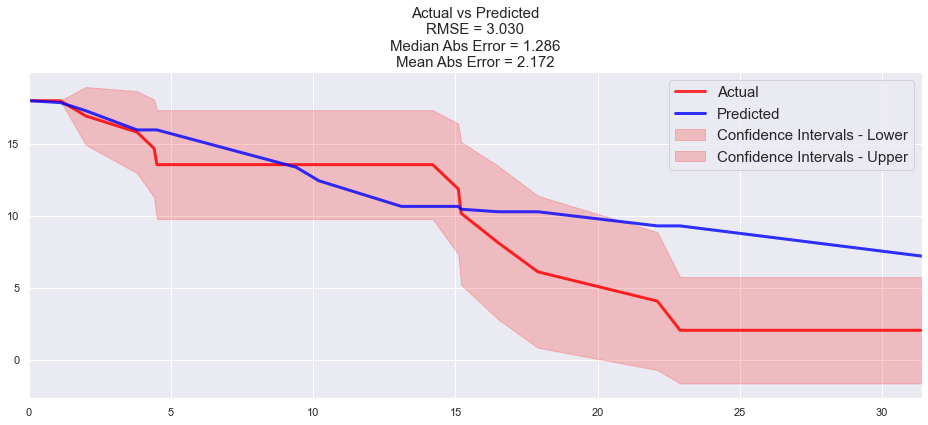

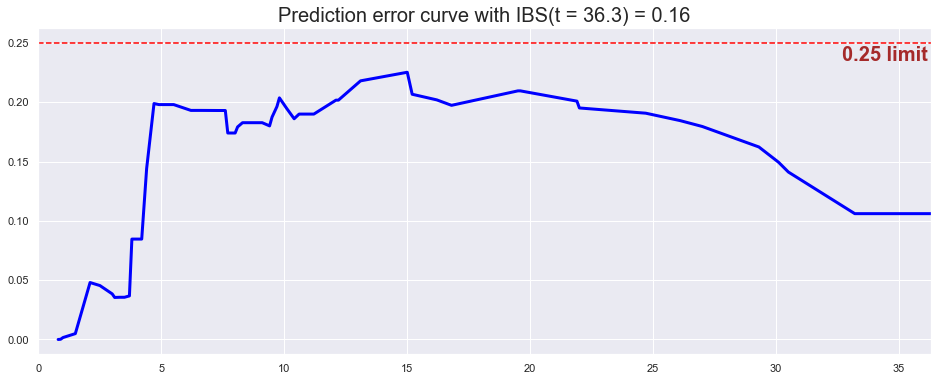

C-index: 0.76
IBS: 0.16

 2 of kfold 5


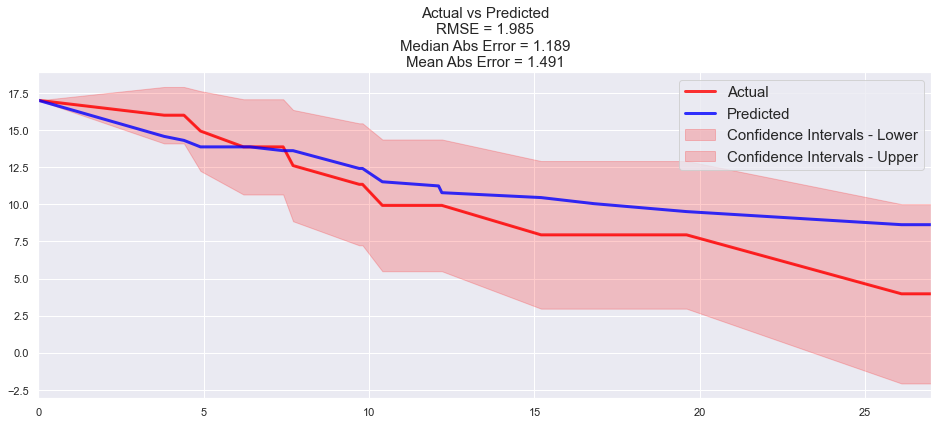

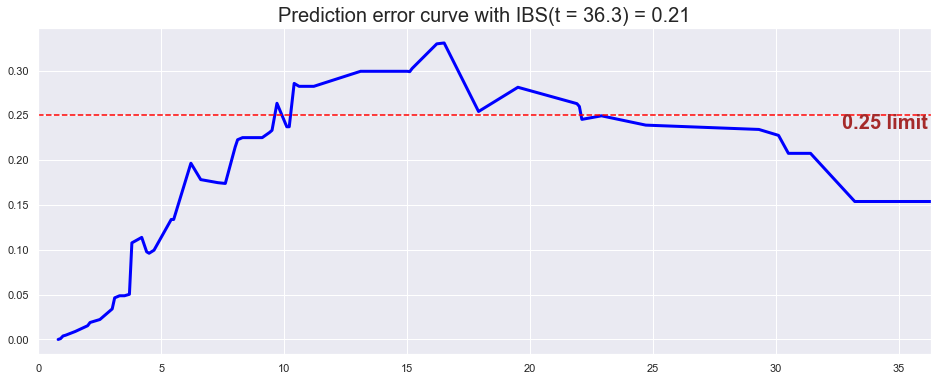

C-index: 0.58
IBS: 0.21

 3 of kfold 5


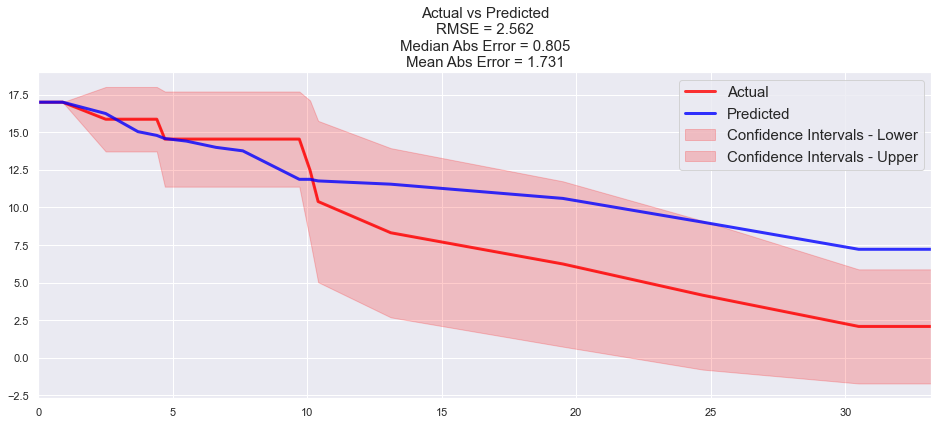

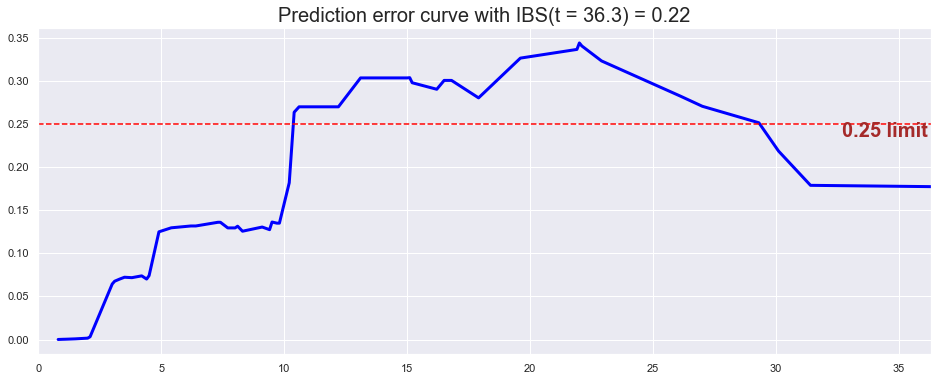

C-index: 0.54
IBS: 0.22

 4 of kfold 5


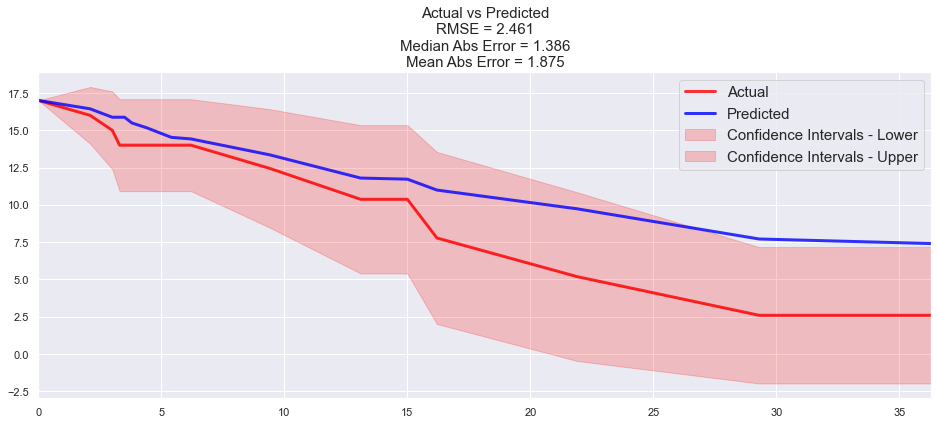

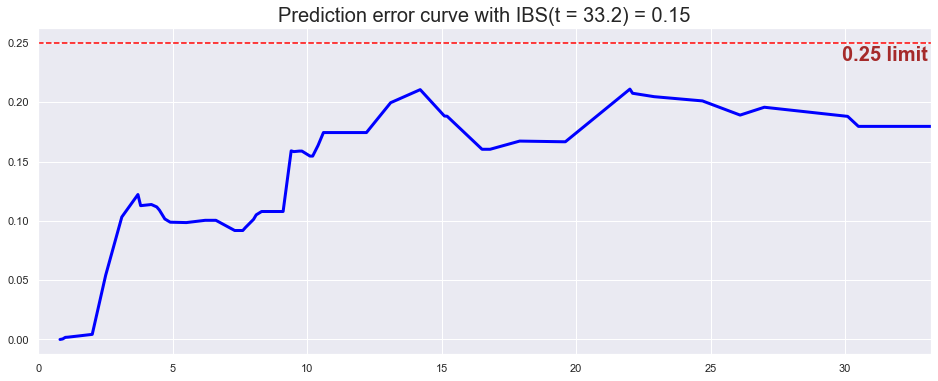

C-index: 0.70
IBS: 0.15

 5 of kfold 5


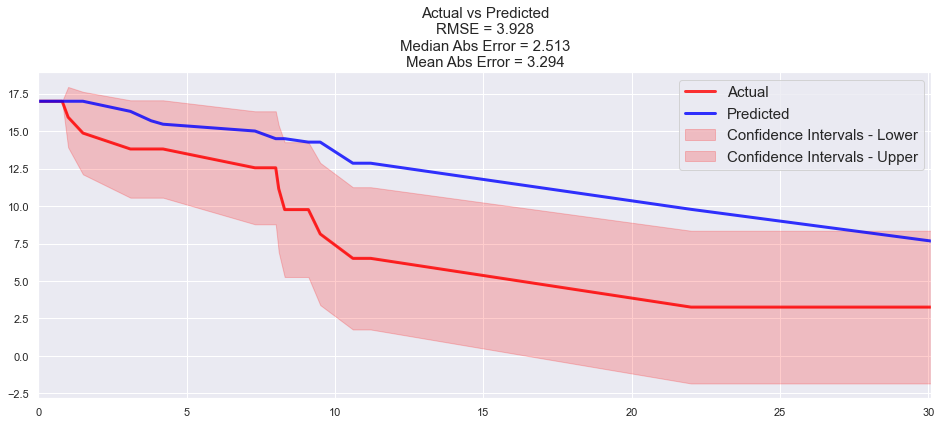

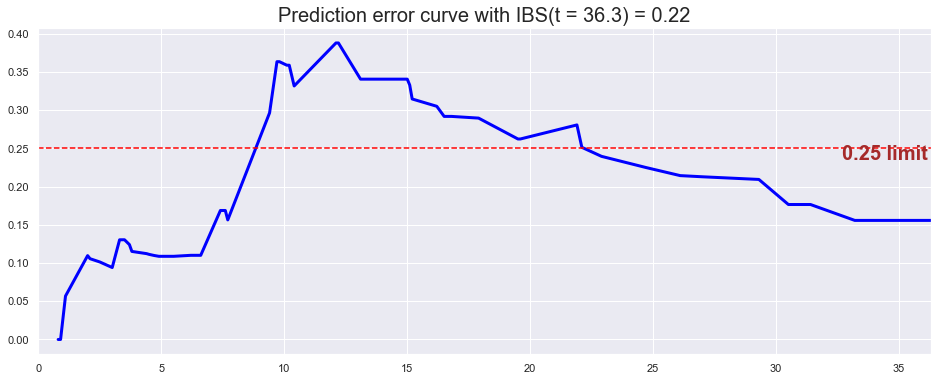

C-index: 0.70
IBS: 0.22

 

Processing: gtv_0_clin_variables.csv

Feature Selecting... 

Computing feature selection...

dropping 'original_firstorder_Energy' at index: 22
dropping 'original_shape_MeshVolume' at index: 14
dropping 'original_firstorder_Maximum' at index: 24
dropping 'original_glcm_SumAverage' at index: 56
dropping 'original_glcm_SumSquares' at index: 57
dropping 'original_shape_VoxelVolume' at index: 18
dropping 'original_glszm_LargeAreaEmphasis' at index: 90
dropping 'original_gldm_GrayLevelVariance' at index: 61
dropping 'original_glcm_DifferenceEntropy' at index: 41
dropping 'original_firstorder_Variance' at index: 33
dropping 'original_glcm_Idmn' at index: 43
dropping 'original_gldm_HighGrayLevelEmphasis' at index: 58
dropping 'original_glrlm_RunLengthNonUniformityNormalized' at index: 75
dropping 'FFLP_in_months' at index: 1
dropping 'original_firstorder_TotalEnergy' at index: 30
dropping 'FFLP' at index: 0
dropping 'original_firstorder_Entropy' at index: 18
droppi

10 12 15 0.5989612882289209
10 12 20 0.6094878138978708
10 15 1 0.7136525668735154
10 15 2 0.6620509917881129
10 15 3 0.6518963241480102
10 15 4 0.6226168455577215
10 15 5 0.6735268847751359
10 15 10 0.6679765272132954
10 15 12 0.6831640954057763
10 15 15 0.6885567732515151
10 15 20 0.6542081060051723
12 1 1 0.6990493025788306
12 1 2 0.5983848606711745
12 1 3 0.6692441352355897
12 1 4 0.6444782317366226
12 1 5 0.6741593398393841
12 1 10 0.7111166879942044
12 1 12 0.6413968114063558
12 1 15 0.6704042776896209
12 1 20 0.6757960015779542
12 2 1 0.7149255463865787
12 2 2 0.6856655118026772
12 2 3 0.6640682575022225
12 2 4 0.6559426483106606
12 2 5 0.6922387818685831
12 2 10 0.6934346203482453
12 2 12 0.6416983252713806
12 2 15 0.6422468373682884
12 2 20 0.7019256050170902
12 3 1 0.6670302008653363
12 3 2 0.6462362504746245
12 3 3 0.6789449074479919
12 3 4 0.6666932486707485
12 3 5 0.6586898186139366
12 3 10 0.643839045619892
12 3 12 0.6697286263738756
12 3 15 0.6499868906290488
12 3 20 0.6

50 10 1 0.7079697007926338
50 10 2 0.6985674681133627
50 10 3 0.6974422001708943
50 10 4 0.6918010524019023
50 10 5 0.6858768920548711
50 10 10 0.6984414978628593
50 10 12 0.6994573188072841
50 10 15 0.6883469170250123
50 10 20 0.6210355316232546
50 12 1 0.7096598937588543
50 12 2 0.6777615658179129
50 12 3 0.7063261637487308
50 12 4 0.7080875555348247
50 12 5 0.7127951594179515
50 12 10 0.7291188499677638
50 12 12 0.6850516967626566
50 12 15 0.6701750500303706
50 12 20 0.6617044162945995
50 15 1 0.7379640773459766
50 15 2 0.7490018544416932
50 15 3 0.7101406019376819
50 15 4 0.7241946342037751
50 15 5 0.6879274574141568
50 15 10 0.6647414435964556
50 15 12 0.6981274841433212
50 15 15 0.6901368036743888
50 15 20 0.6716318606128484
100 1 1 0.706001303190157
100 1 2 0.712161984899775
100 1 3 0.6533037388751431
100 1 4 0.6627254805408033
100 1 5 0.6576497773987373
100 1 10 0.6604191689229372
100 1 12 0.6782095831555448
100 1 15 0.6869209778925021
100 1 20 0.6972265240324799
100 2 1 0.6372

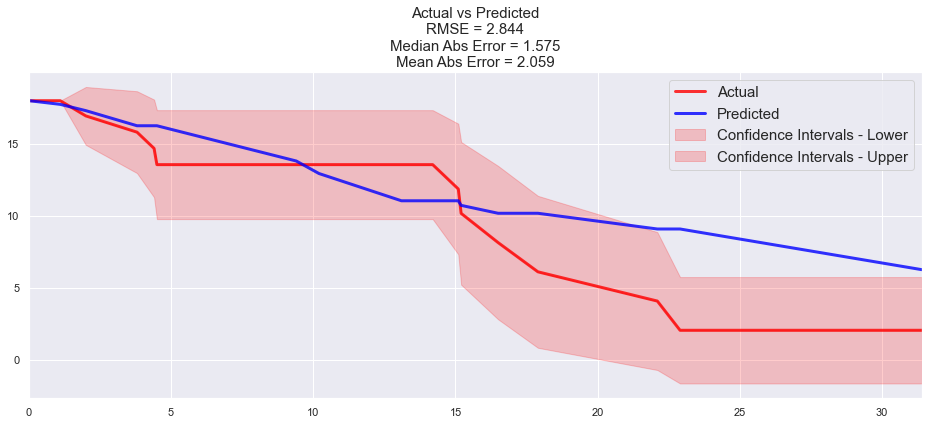

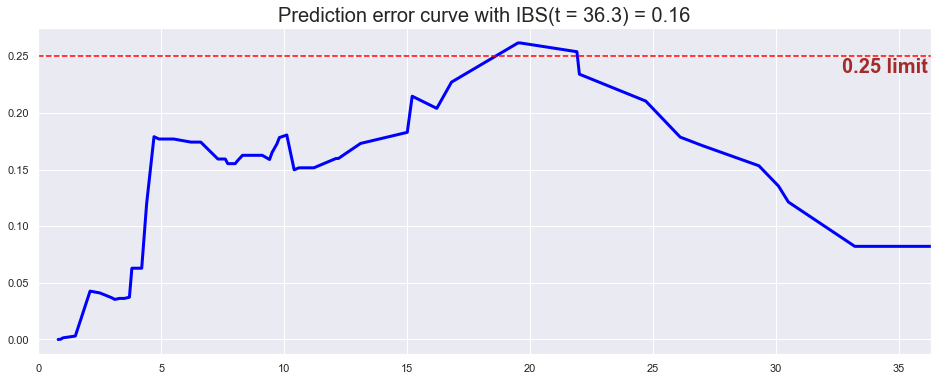

C-index: 0.53
IBS: 0.16

 2 of kfold 5


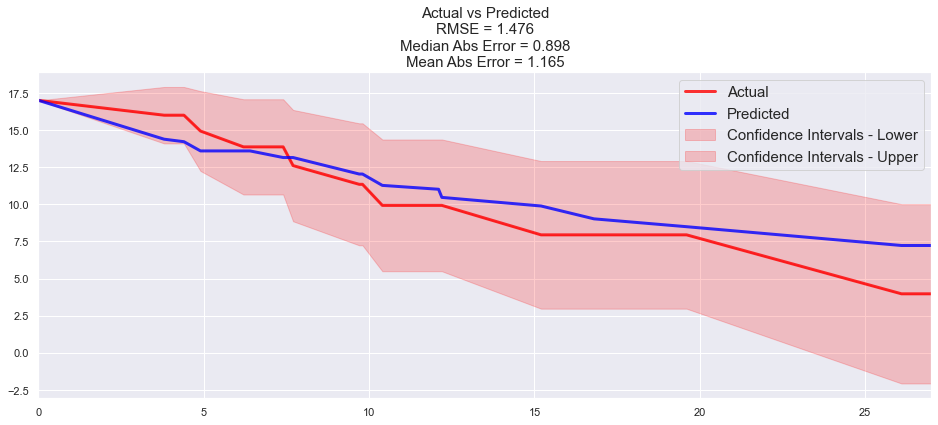

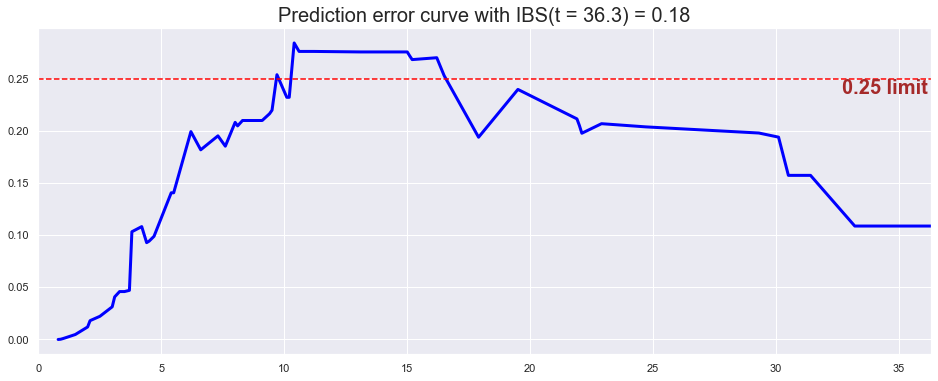

C-index: 0.60
IBS: 0.18

 3 of kfold 5


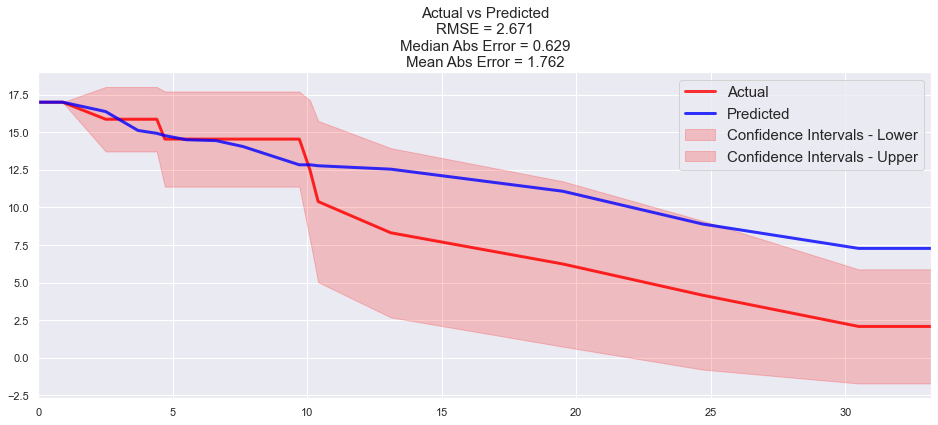

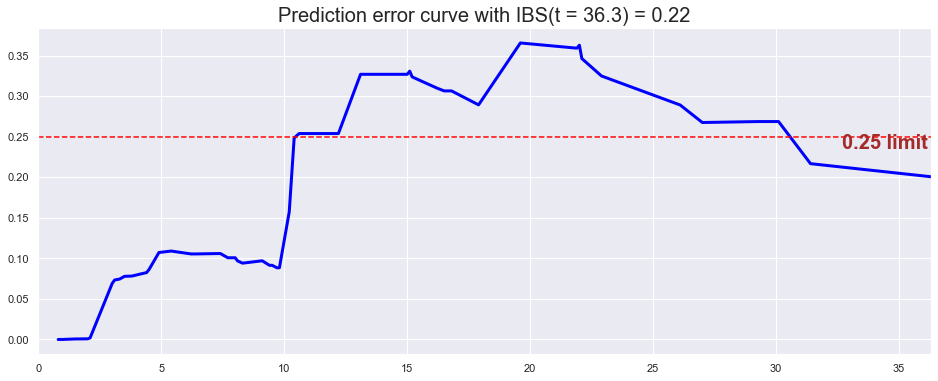

C-index: 0.51
IBS: 0.22

 4 of kfold 5


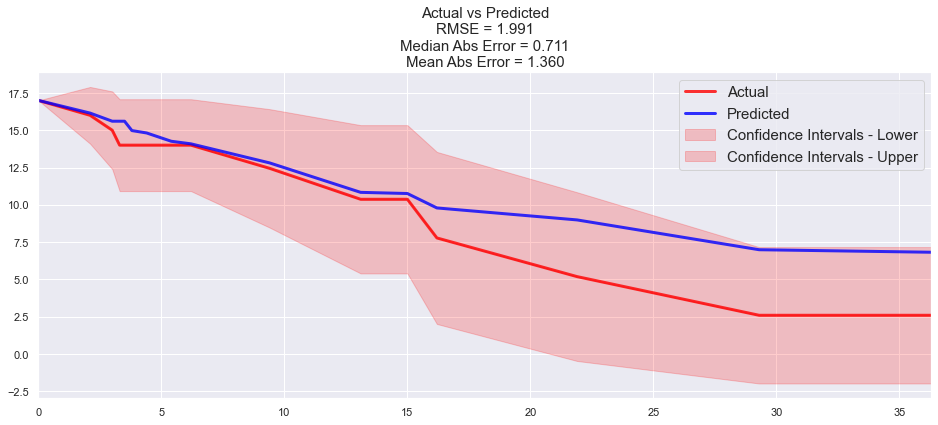

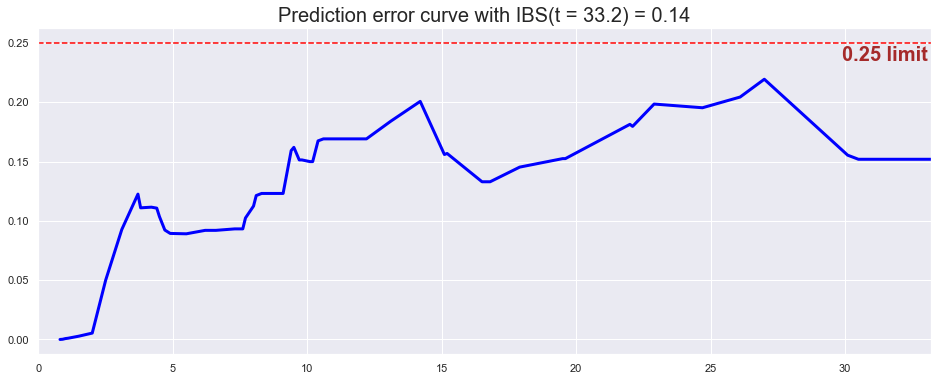

C-index: 0.87
IBS: 0.14

 5 of kfold 5


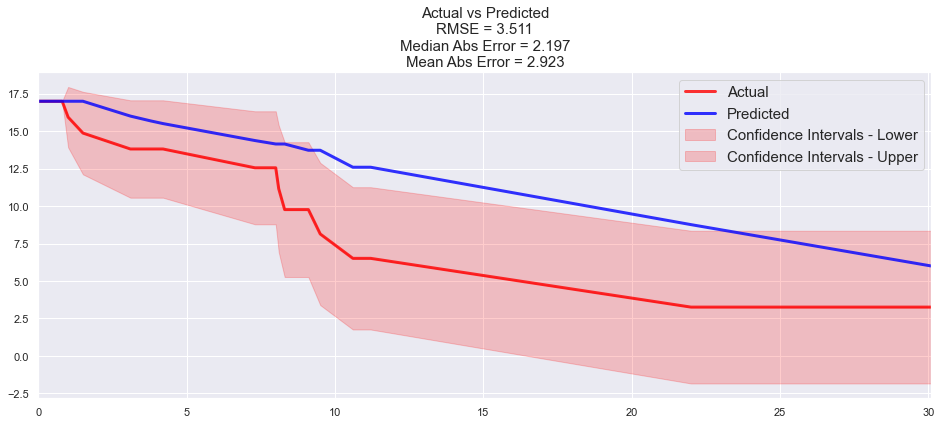

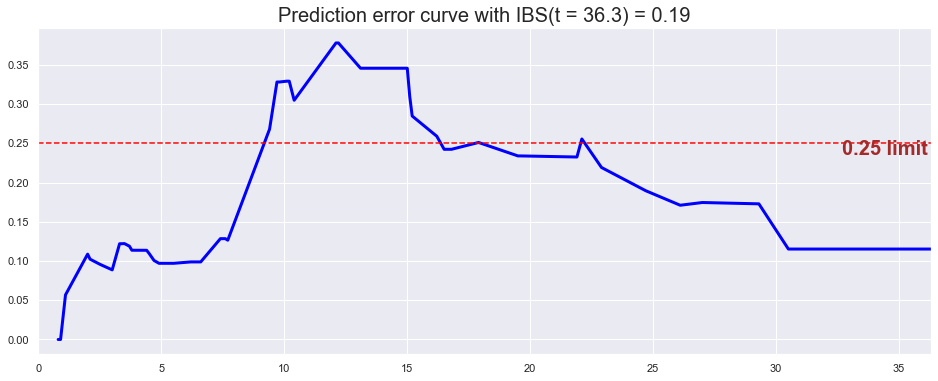

C-index: 0.70
IBS: 0.19

 

                                Data  Best Gridsearch CI    CI Avg    CI STD  \
0                            gtv.csv            0.765267  0.612734  0.086867   
1                  liver_sub_gtv.csv            0.673656  0.634586  0.031609   
2                 liver_plus_gtv.csv            0.678103  0.583756  0.054237   
3             gtv_clin_variables.csv            0.740134  0.667673  0.083078   
4   liver_sub_gtv_clin_variables.csv            0.668749  0.575784  0.055725   
5  liver_plus_gtv_clin_variables.csv            0.657524  0.607201  0.076043   
6            clin_variables_only.csv            0.762340  0.720751  0.064459   
7                          gtv_0.csv            0.724885  0.657327  0.095156   
8           gtv_0_clin_variables.csv            0.788548  0.641443  0.146818   

    IBS Avg   IBS STD  Num Trees  Max Depth  Min Node  
0  0.168777  0.021980       10.0        3.0       2.0  
1  0.212864  0.028087       12.0       10.0       2.0  
2  

In [11]:
# iterating thought each dataset
# all results will be stored in a dataframe with columns "CI, CI STD, IBS, IBS"

results = []

for data_name in data_list:

    # Running feature selection on the data
    
    print('Processing: ' + data_name + '\n')
    processed_file_name = 'filtered_' + data_name 
    
    print('Feature Selecting... \n')
    if(not(os.path.exists(processed_file_name))):
        print('Computing feature selection...\n')
        filtered_data = feature_select(data_name)
    else:
        filtered_data = pd.read_csv(processed_file_name)
        print('Loading existing selected features...\n')
    print('\n \n')

    # running gridsearch
    
    print('Running gridsearch on: ' + data_name + '\n')
    gridsearch_file_name = 'gridsearch_' + data_name 
    
    if(not(os.path.exists(gridsearch_file_name))):
        print('Computing gridsearch...\n')
        (c_index_best, num_tree_best, max_depth_best, min_node_best) = gridsearch(filtered_data, data_name)
        print((c_index_best, num_tree_best,max_depth_best, min_node_best))
    else:
        gridsearch_df = pd.read_csv(gridsearch_file_name)
        
        c_index_best = gridsearch_df['Values'][0]
        num_tree_best = gridsearch_df['Values'][1]
        max_depth_best = gridsearch_df['Values'][2]
        min_node_best = gridsearch_df['Values'][3]
        
        #print(c_index_best)
        print('Loading existing gridsearch hyperparameters...\n')
        
    # generating model form best gridsearch combination

    print('Evaluating K-folds with best hyperparameter combination...\n')
    (CIAvg, CIStd, IBSAvg, IBSStd) = generate_survival_model(filtered_data, num_tree_best, max_depth_best, min_node_best)
    
    results.append([data_name, c_index_best, CIAvg, CIStd, IBSAvg, IBSStd, num_tree_best, max_depth_best, min_node_best])
    print('\n \n')

results_DF = pd.DataFrame(results, columns = ['Data', 'Best Gridsearch CI', 'CI Avg','CI STD','IBS Avg', 'IBS STD', 'Num Trees', 'Max Depth', 'Min Node'])

print(results_DF)

In [12]:
results_DF

Data  Best Gridsearch CI    CI Avg    CI STD  \
0                            gtv.csv            0.765267  0.612734  0.086867   
1                  liver_sub_gtv.csv            0.673656  0.634586  0.031609   
2                 liver_plus_gtv.csv            0.678103  0.583756  0.054237   
3             gtv_clin_variables.csv            0.740134  0.667673  0.083078   
4   liver_sub_gtv_clin_variables.csv            0.668749  0.575784  0.055725   
5  liver_plus_gtv_clin_variables.csv            0.657524  0.607201  0.076043   
6            clin_variables_only.csv            0.762340  0.720751  0.064459   
7                          gtv_0.csv            0.724885  0.657327  0.095156   
8           gtv_0_clin_variables.csv            0.788548  0.641443  0.146818   

    IBS Avg   IBS STD  Num Trees  Max Depth  Min Node  
0  0.168777  0.021980       10.0        3.0       2.0  
1  0.212864  0.028087       12.0       10.0       2.0  
2  0.165236  0.014456       12.0        2.0      20.0  
3  0.176359  0.031222       15.0       10.0       3.0  
4  0.165153  0.016259       10.0        4.0      15.0  
5  0.166073  0.013237       10.0       15.0      20.0  
6  0.150193  0.010646       12.0        1.0       1.0  
7  0.191964  0.031280       20.0       10.0       2.0  
8  0.179289  0.031172       12.0       15.0       4.0